# Introduction

By clicking on this link you can find the video that pertains to this project: https://youtu.be/6S5L2dgX5qk

<span style='color:DarkBlue; font-size:large' >
This is our entry for the Fall 2023 Capstone Project Kaggle competition.  The goal is to find the optimum predictor for Telecon Customer Churn.  Customer Churn is a vital issue for all companies providing customer service.  Churn represents lost customers over a period of time due to service dissatifaction, disinterest or to a competitor.  Losing customers to churn stifles a companies growth and can have a serious impact on its financials health.  This project will use available customer data to determine if they are a likely candidate to churn.  Using this prediction, the Telecon company may take action to prevent this loss. 
</span>

# Preprocessing
## Data Understanding

Link: [Telecon Customer Churn](https://www.kaggle.com/competitions/uwf-ml-for-ds-fall-2023-capstone-project/data)

- <b>ID</b>: Unique identifier for each customer for submission.
- <b>customerID</b>: Unique company identifier for each customer (alpha-numeric 'dddd-ccccc')
- <b>gender</b>: ( Male / Female)
- <b>SeniorCitizen</b>: Is a senior citizen (1) or not (0).
- <b>Partner</b>: Has a partner (Yes) or not (No).
- <b>Dependents</b>: Has dependents (Yes) or not (No).
- <b>tenure</b>: Continuous integer variable representing the number of months the customer has been with the company.
- <b>PhoneService</b>: If the customer has phone service (Yes) or not (No).
- <b>MultipleLines</b>: Categorical variable indicating the type of phone service the customer has (Yes/No/No phone service).
- <b>InternetService</b>: Categorical variable indicating the type of internet service the customer has (DSL, Fiber optic, No).
- <b>OnlineSecurity</b>: Categorical variable indicating if the customer has online security or not. (Yes, No, No internet service)
- <b>OnlineBackup</b>: Categorical variable indicating if the customer has online backup or not. (Yes, No, No internet service)
- <b>DeviceProtection</b>: Categorical variable indicating if the customer has device protection or not.(Yes, No, No internet service)
- <b>TechSupport</b>: Categorical variable indicating if the customer has tech support or not. (Yes, No, No internet service)
- <b>StreamingTV</b>: Categorical variable indicating if the customer has streaming TV or not. (Yes, No, No internet service)
- <b>StreamingMovies</b>: Categorical variable indicating if the customer has streaming movies or not. (Yes, No, No internet service)
- <b>Contract</b>: Categorical variable representing the type of contract the customer has (Month-to-month, One year, Two year).
- <b>PaperlessBilling</b>: If the customer has opted for paperless billing (Yes) or not (No).
- <b>PaymentMethod</b>: Categorical variable representing the payment method used by the customer. (Electronic check, Mailed check, Credit card)
- <b>MonthlyCharges</b>: Continuous real number variable representing the monthly charges for the customer.
- <b>TotalCharges</b>: Continuous real number variable representing the total charges for the customer.
- <b>Churn</b>: Target variable column indicating if the customer churned (1) or not (0).


## Setup

<span style='color:DarkBlue; font-size:large' >
The imbalanced-learn library provides a number of resampling techniques including SMOTE, RandomOversampling and RandomUndersampling.  It also provides their own Pipeline which is the same as sklean's Pipeline but allows the inclusion of the resampling, if needed.  More information can be found in our textbook, page 203.
</span>

In [4]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import sys
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import imblearn
import xgboost as xgb
import json
import IPython

from collections import Counter

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from pandas.api.types import is_object_dtype

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_colwidth', 255)                  # print long table values (params)
set_config(display="diagram")                               # show the pipeline
set_config(transform_output="pandas")                       # panda return from fit

/kaggle/input/churn-data-files/sample_submission.csv
/kaggle/input/churn-data-files/train.csv
/kaggle/input/churn-data-files/test.csv


In [7]:
# There can be a lot of waiting when running parts of this notebook.  This line helps notify when the wait is over.

def jobs_finished():
    IPython.display.display(IPython.display.Audio(url='https://cdn.pixabay.com/audio/2022/03/15/audio_64cc629d5f.mp3', autoplay=True))

## Data Examination

In [8]:
pd.set_option("display.max_columns", None)
training_datafile = "/kaggle/input/churn-data-files/train.csv"
df = pd.read_csv(training_datafile)


orig_column_labels = df.columns
print('There are %s features and %d samples to train on.' % (df.shape[1], df.shape[0]))
print()
display(df.head(3))

There are 22 features and 5634 samples to train on.



,ID,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,3739,4950-BDEUX,Male,0,No,No,35,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,1701.65,0
1,3152,7993-NQLJE,Male,0,Yes,Yes,15,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,75.10,1151.55,0
2,4861,7321-ZNSLA,Male,0,Yes,Yes,13,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Mailed check,40.55,590.35,0


In [9]:
print(df.dtypes)

ID                    int64
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object


<span style='color:DarkBlue; font-size:large' >
Most of these features are of the expected types.  
    
- The SeniorCitizen and Churn are 0/1 int64 already.  
- Tenure is a continuous integer.  
- MonthlyCharges is a continuous real number.  
- All the categorical data features are objects.
- Gender, SeniorCitizen, Partner, Dependents, PhoneService and PaperlessBilling are binary categories.  
- Contract -might- be ordinal. (each monthly/ each year/ each 2 years)
- <b>NOTE</b>: The TotalCharges is showing as an object when we were expecting a float64.  We will have to look at this closer and likely convert to a number.
</span>

<span style='color:DarkBlue; font-size:large' >
<b>TotalCharges</b> is supposed to be a continuous real number according the data descriptions
</span>

### Check for data missing or out-of-range

In [10]:
def view_rows_with_missing_data(df):
#     feature_list = df_fc.columns
    bad_rows=0
    for feature in df.columns:
        if is_object_dtype(df[feature]):
            missing_value_markers = df[feature].str.contains(np.nan, regex=False)
            num_missing = missing_value_markers.sum()
            print ('["%s"] had %d missing values.' % (feature, num_missing))
            bad_rows += num_missing
            print ('Current values include: ', end='')
            print(df[feature].unique())
            print()
        else:
            missing_value_markers = df[feature].isnull()
            num_missing = missing_value_markers.sum()
            bad_rows += num_missing
            print ('["%s"] had %d missing values.' % (feature, num_missing))
            min = float(df[feature].min())
            max = float(df[feature].max())          
            print ('Current values include: %.1f - %.1f' % (min,max))
            print()
    print('Total bad rows: %s ' % bad_rows)


# Making temporary change to TotalCharges - should be continuous real numbers.
df_temp = df.copy(deep=True)
df_temp['TotalCharges'] = pd.to_numeric(df_temp['TotalCharges'],errors='coerce')
view_rows_with_missing_data(df_temp)


["ID"] had 0 missing values.
Current values include: 1.0 - 7043.0

["customerID"] had 0 missing values.
Current values include: ['4950-BDEUX' '7993-NQLJE' '7321-ZNSLA' ... '6402-ZFPPI' '3594-BDSOA'
 '6490-FGZAT']

["gender"] had 0 missing values.
Current values include: ['Male' 'Female']

["SeniorCitizen"] had 0 missing values.
Current values include: 0.0 - 1.0

["Partner"] had 0 missing values.
Current values include: ['No' 'Yes']

["Dependents"] had 0 missing values.
Current values include: ['No' 'Yes']

["tenure"] had 0 missing values.
Current values include: 0.0 - 72.0

["PhoneService"] had 0 missing values.
Current values include: ['No' 'Yes']

["MultipleLines"] had 0 missing values.
Current values include: ['No phone service' 'No' 'Yes']

["InternetService"] had 0 missing values.
Current values include: ['DSL' 'Fiber optic' 'No']

["OnlineSecurity"] had 0 missing values.
Current values include: ['No' 'Yes' 'No internet service']

["OnlineBackup"] had 0 missing values.
Current val

In [11]:
df_temp.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5634.0,3511.330316,2044.824840,1.00,1736.2500,3490.500,5297.7500,7043.00
SeniorCitizen,5634.0,0.163294,0.369667,0.00,0.0000,0.000,0.0000,1.00
tenure,5634.0,32.485091,24.568744,0.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,5634.0,64.929961,30.138105,18.40,35.6625,70.500,90.0000,118.75
TotalCharges,5626.0,2302.604266,2279.173176,18.85,407.2750,1398.125,3838.6125,8684.80
Churn,5634.0,0.265353,0.441560,0.00,0.0000,0.000,1.0000,1.00


# Examine Features and Relationships

<span style='color:DarkBlue; font-size:large' >
Before the various ML Models can help make predictions, the features must be checked for relevancy and categorical data must be encoded.  
</span>

In [12]:
def show_effect_distribution(name, df, feature, target, ordinal_map = None, show_labels = True):

    if ordinal_map is None:
        sorting_map = {label: idx for idx, label in enumerate(np.unique(df[feature]))}
    else:
        sorting_map = ordinal_map
    colors = ['b', 'r', 'g', 'y', 'k']
    crosstab = pd.crosstab(df[feature], df[target])
    crosstab_rowsum = crosstab.sum(axis=1)
    crosstab_stdcol = crosstab.div(crosstab_rowsum, axis=0)
    feature_map = sorted(sorting_map, key=sorting_map.get, reverse=False)
    crosstab_stdcol_reindexed = crosstab_stdcol.reindex(feature_map)
    crosstab_rowsum_reindexed = crosstab_rowsum.reindex(feature_map)

    f, axes = plt.subplots(1, 2, figsize=(8, 4)) 
    label = name + " Category"
    ax0 = crosstab_stdcol_reindexed.plot(kind ='barh', title = target + '%', ax=axes[0], xlabel=label, legend='reverse', color=colors)
    axes[1].pie(crosstab_rowsum_reindexed, labels=feature_map)
    title = name + " Count Distribution"
    axes[1].set_title(title)

    f.tight_layout()
    plt.show()


# temp fix for known problems
df_temp = df.copy(deep=True)
df_temp['TotalCharges'] = pd.to_numeric(df_temp['TotalCharges'],errors='coerce')

## Gender

<span style='color:DarkBlue; font-size:large' >
Distribution and Churn likelihood look nearly identical.
</span>

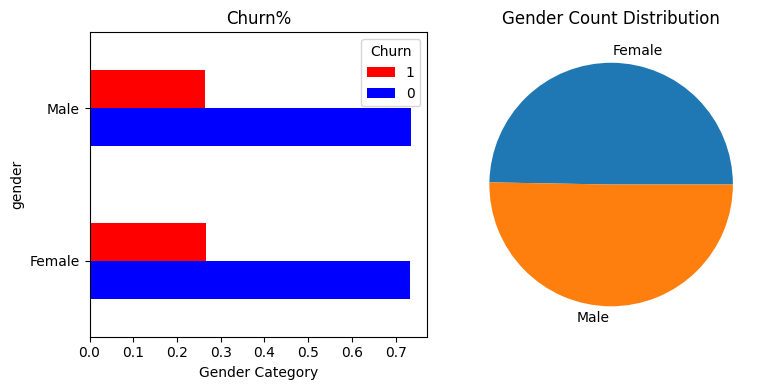

In [13]:
show_effect_distribution('Gender', df_temp, 'gender', 'Churn', show_labels = True)

## Senior Citizen

<span style='color:DarkBlue; font-size:large' >
Interestingly, Seniors seem to Churn more often.

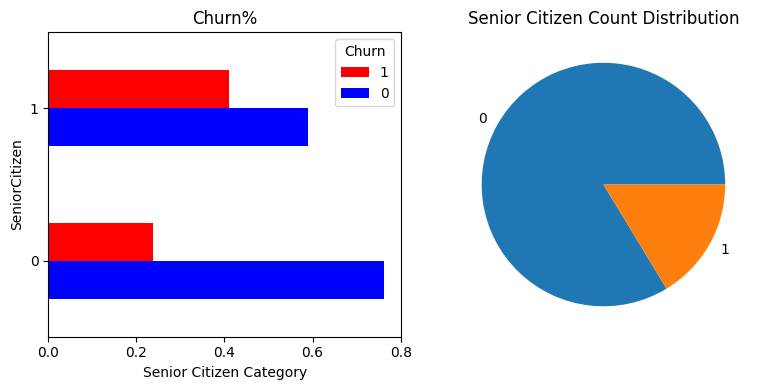

In [14]:
show_effect_distribution('Senior Citizen', df_temp, 'SeniorCitizen', 'Churn', show_labels = True)

## Has Partner

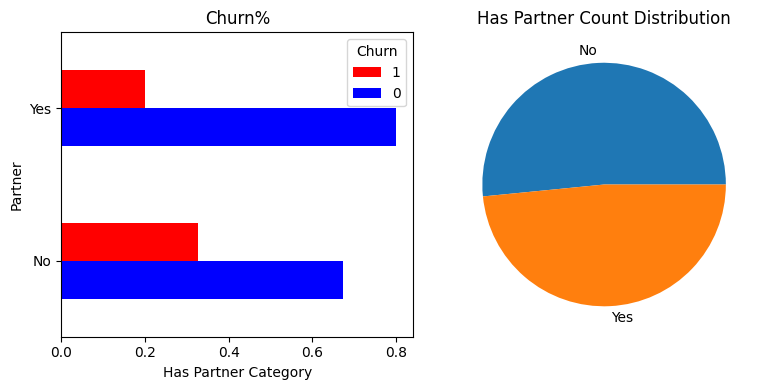

In [15]:
show_effect_distribution('Has Partner', df_temp, 'Partner', 'Churn', show_labels = True)

## Has Dependents

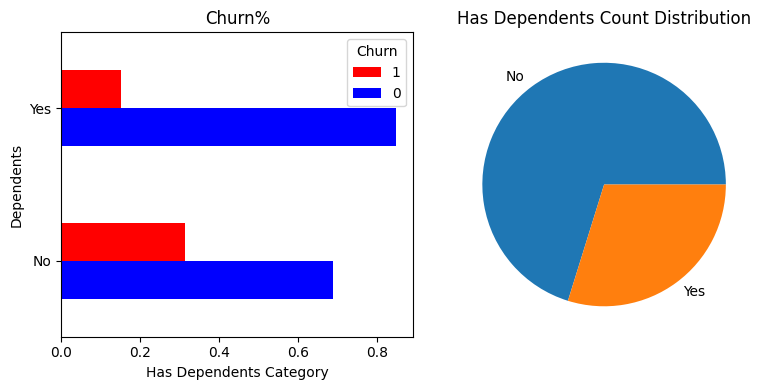

In [16]:
show_effect_distribution('Has Dependents', df_temp, 'Dependents', 'Churn', show_labels = True)
           

## Tenure - Months With Company

<span style='color:DarkBlue; font-size:large' >
The labels are awful (working on that).  I think there is a 'group-by' solution.  <br>
However, this shows that people who are longer with a company tend to stay with the company.

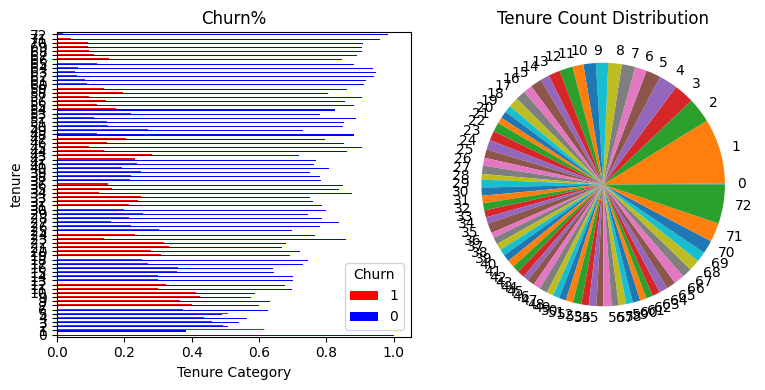

In [17]:
show_effect_distribution('Tenure', df_temp, 'tenure', 'Churn', show_labels = True)

## Has Phone Service

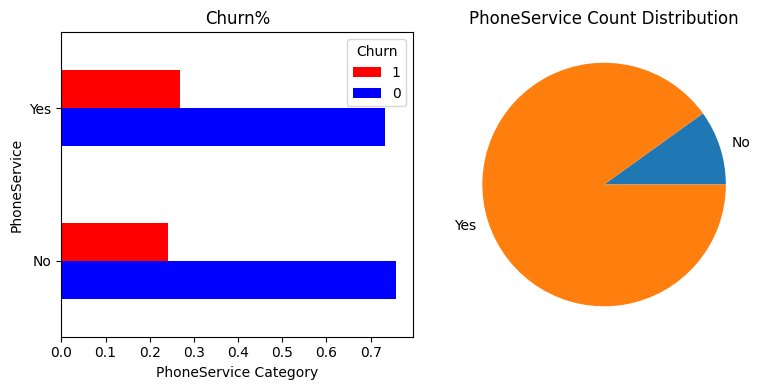

In [18]:
show_effect_distribution('PhoneService', df_temp, 'PhoneService', 'Churn', show_labels = True)
   

## Has Multiple Lines

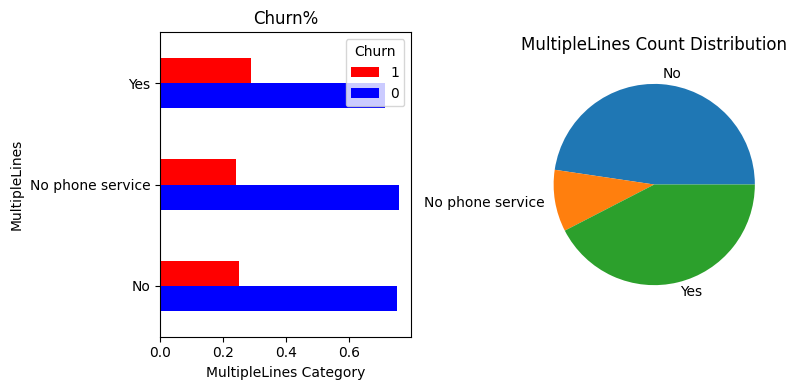

In [19]:
show_effect_distribution('MultipleLines', df_temp, 'MultipleLines', 'Churn', show_labels = True)    

## Has Internet Service

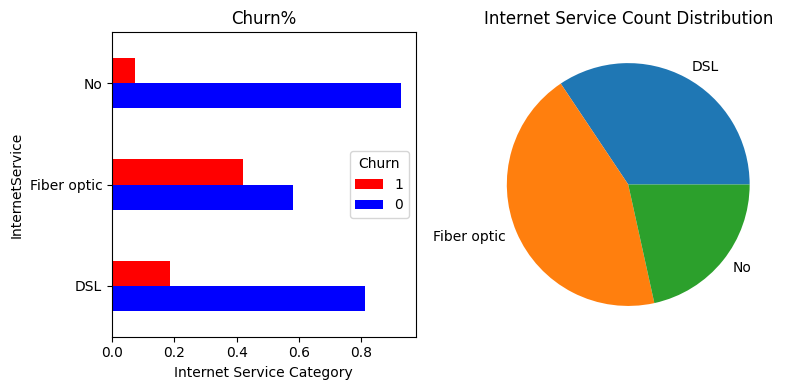

In [20]:

show_effect_distribution('Internet Service', df_temp, 'InternetService', 'Churn', show_labels = True)

## Has Online Security

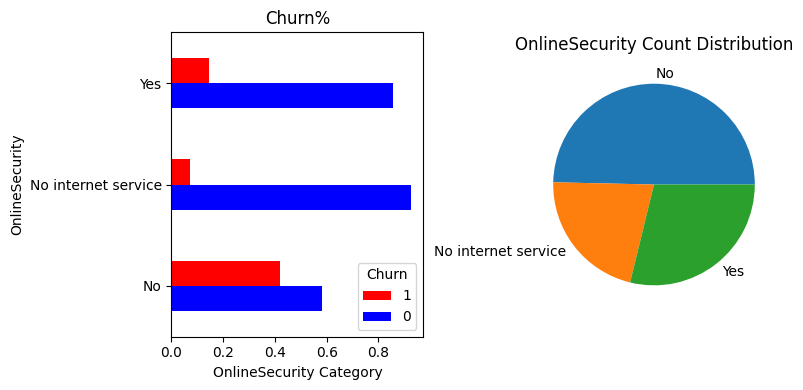

In [21]:
   
show_effect_distribution('OnlineSecurity', df_temp, 'OnlineSecurity', 'Churn', show_labels = True)

## Has Online Backup

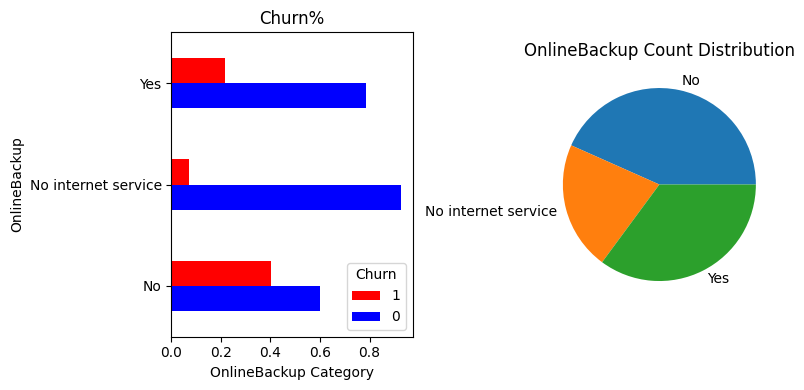

In [22]:
show_effect_distribution('OnlineBackup', df_temp, 'OnlineBackup', 'Churn', show_labels = True)

## Has Device Protection

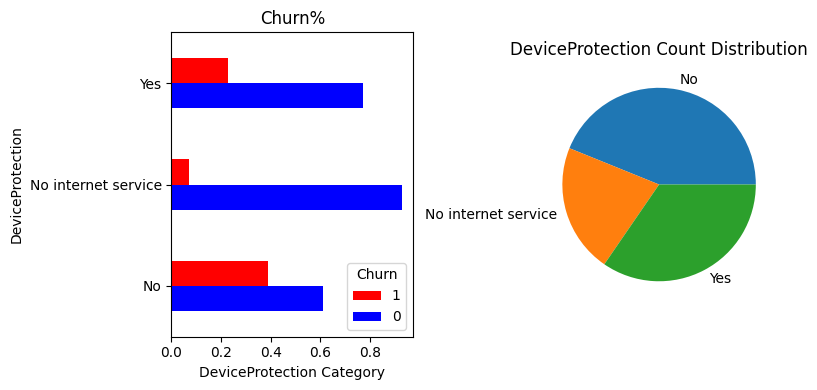

In [23]:
show_effect_distribution('DeviceProtection', df_temp, 'DeviceProtection', 'Churn', show_labels = True)

## Receives Tech Support

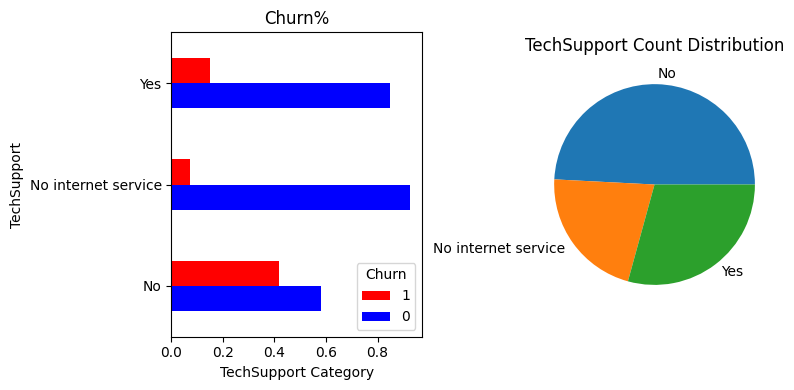

In [24]:
show_effect_distribution('TechSupport', df_temp, 'TechSupport', 'Churn', show_labels = True)

## Has Streaming TV

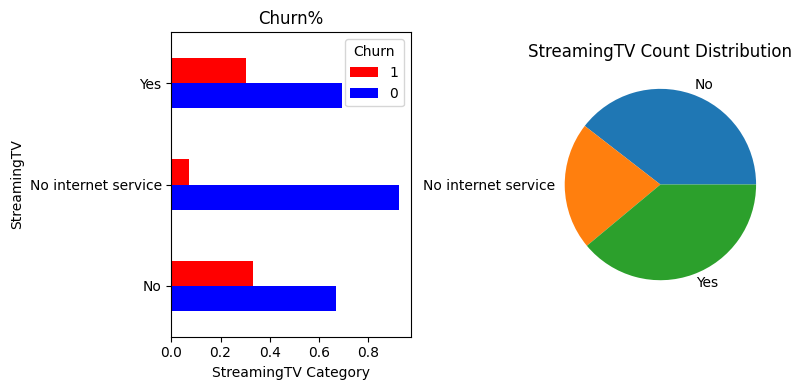

In [25]:
show_effect_distribution('StreamingTV', df_temp, 'StreamingTV', 'Churn', show_labels = True)

## Has Streaming Movies

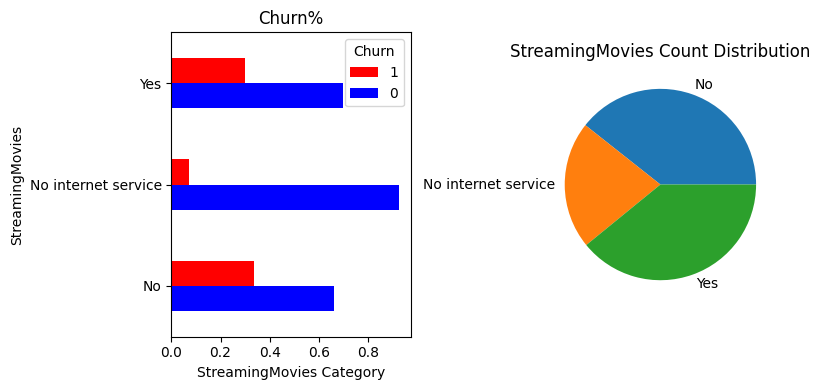

In [26]:
show_effect_distribution('StreamingMovies', df_temp, 'StreamingMovies', 'Churn', show_labels = True)

## Contract - (Monthly, Annually, Biennial)

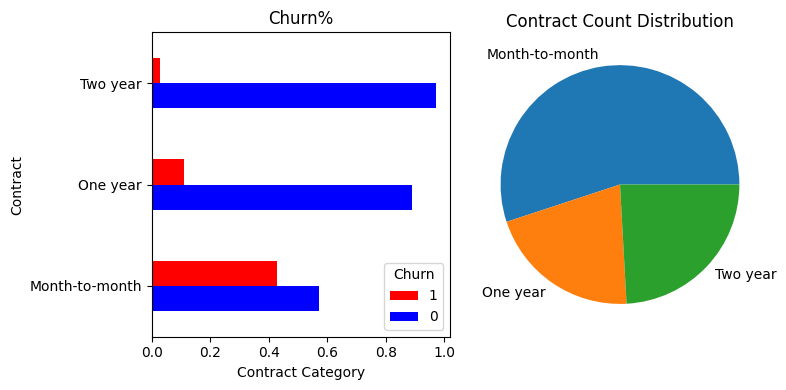

In [27]:
show_effect_distribution('Contract', df_temp, 'Contract', 'Churn', show_labels = True)

## Paperless Billing

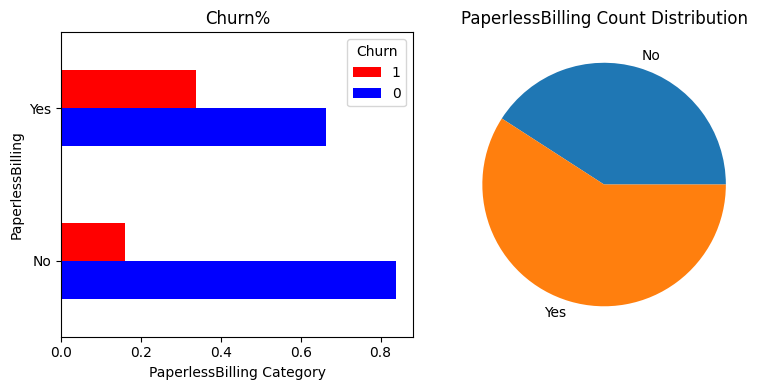

In [28]:
show_effect_distribution('PaperlessBilling', df_temp, 'PaperlessBilling', 'Churn', show_labels = True)

## Payment Method

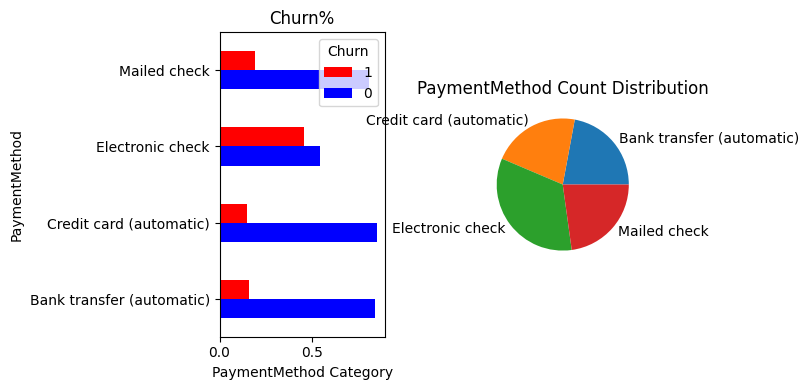

In [29]:
show_effect_distribution('PaymentMethod', df_temp, 'PaymentMethod', 'Churn', show_labels = True)

## Monthly Charge

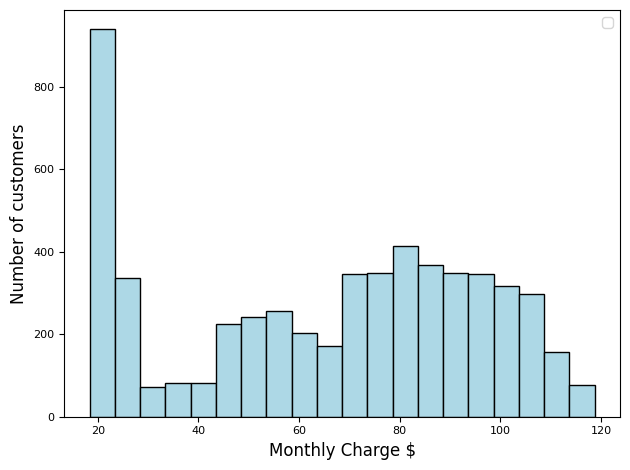

In [30]:

plt.rc('ytick', labelsize = 8)
plt.rc('xtick', labelsize = 8)
plt.legend()
plt.ylabel('Number of customers', size='large')
plt.xlabel('Monthly Charge $', size= 'large')
plt.hist(df_temp['MonthlyCharges'], color='lightblue', bins = 20,  edgecolor='black')
plt.tight_layout()
plt.show() 

## Total Charges

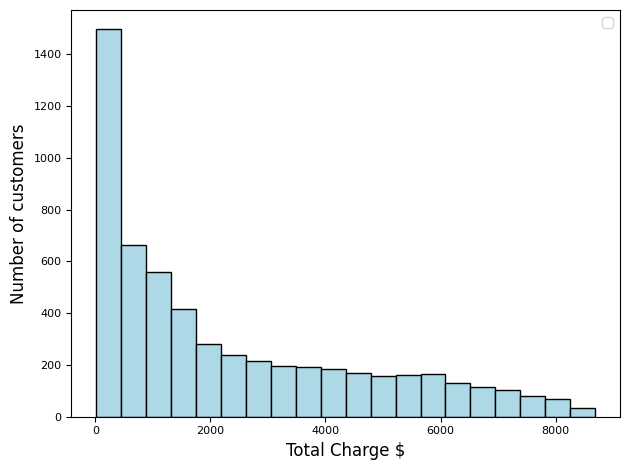

In [31]:
plt.rc('ytick', labelsize = 8)
plt.rc('xtick', labelsize = 8)
plt.legend()
plt.ylabel('Number of customers', size='large')
plt.xlabel('Total Charge $', size= 'large')

plt.hist(df_temp['TotalCharges'], color='lightblue', bins = 20,  edgecolor='black')
plt.tight_layout()
plt.show() 

### TotalCharge = tenure x MonthlyCharge  (correlation?)

<span style='color:DarkBlue; font-size:large' >
There is a concern that we have some strongly correlated data here between TotalCharges, tenure and MonthlyCharges.  This can be confirmed with a few steps.
</span>

In [32]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
correlation_data = df_temp.loc[:,numeric_features].corr()
correlation_data

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.256700,0.829433
MonthlyCharges,0.256700,1.000000,0.653969
TotalCharges,0.829433,0.653969,1.000000


In [33]:
def get_correlated_features(df):
    correlation_data = df.corr()
    very_high_correlated_items = []
    highly_correlated_items = []
    moderately_correlated_items = []
    low_correlated_items = []
    correlated_items = {}
    for col_num, y in  enumerate(correlation_data):
        for row_num, x in  enumerate(correlation_data):
            correlation_value = correlation_data.iloc[col_num,row_num]
            if (col_num >= row_num):
                pass
            elif (correlation_value >= 0.90):
                print('Feature %s is very highly correlated with %s' % (df.columns[col_num], df.columns[row_num]))
                very_high_correlated_items.append(df.columns[col_num])
                very_high_correlated_items.append(df.columns[row_num])
            elif (correlation_value >= 0.70):
                print('Feature %s is highly correlated with %s' % (df.columns[col_num], df.columns[row_num]))
                highly_correlated_items.append(df.columns[col_num])
                highly_correlated_items.append(df.columns[row_num])
            elif (correlation_value >= 0.50):
                print('Feature %s is moderately correlated with %s' % (df.columns[col_num], df.columns[row_num]))
                moderately_correlated_items.append(df.columns[col_num])
                moderately_correlated_items.append(df.columns[row_num])
            elif (correlation_value >= 0.30):
                print('Feature %s has a low correlation with feature %s' % (df.columns[col_num], df.columns[row_num]))
                low_correlated_items.append(df.columns[col_num])
                low_correlated_items.append(df.columns[row_num])

    correlated_items.update({'very_high' : list(set(very_high_correlated_items))})
    correlated_items.update({'high' : list(set(highly_correlated_items))})
    correlated_items.update({'moderate' : list(set(moderately_correlated_items))})
    correlated_items.update({'low' : list(set(low_correlated_items))})
    return correlated_items

    # df_bc.drop(found_correlated_filter, axis=1, inplace=True)
correlated_features = get_correlated_features(df_temp.loc[:,numeric_features])
print(correlated_features)


Feature tenure is highly correlated with TotalCharges
Feature MonthlyCharges is moderately correlated with TotalCharges
{'very_high': [], 'high': ['tenure', 'TotalCharges'], 'moderate': ['MonthlyCharges', 'TotalCharges'], 'low': []}


## train_test_split

<span style='color:DarkBlue; font-size:large' >
Before we can begin altering the data values and structure, we will split the the data into training and test sections.  Test will remain isolated from training for the final Model selection. 
</span>

In [34]:
from sklearn.model_selection import train_test_split
X=df.iloc[:,:-1]
feature_labels = df.columns[0:]
y=df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

## Target Balance

Churn Class 0 contains 3311 items  --- (73.464%)
Churn Class 1 contains 1196 items  --- (26.536%)


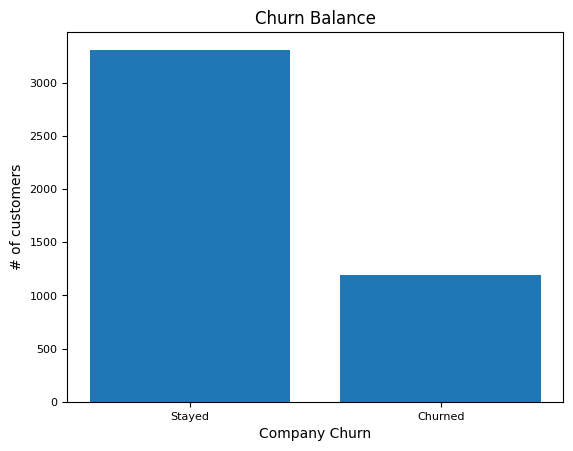

In [35]:
def show_feature_count(feature):
    counter = Counter(feature)
    for counter_key, counter_value in counter.items():
        percent_total = counter_value / len(feature) * 100
        print('Churn Class %s contains %d items  --- (%.3f%%)' % (counter_key, counter_value, percent_total))

    plt.bar(['Stayed', 'Churned'], counter.values())
    
    plt.xlabel('Company Churn')  
    plt.ylabel('# of customers')  
    plt.title("Churn Balance") 
    
    
    plt.show()
    
show_feature_count(y_train)

# Undecided on SMOTE  -  should go into pipeline if used
# before_size = y_train.shape[0]
# oversample = SMOTE()
# X_train_std_smote, y_train_smote = oversample.fit_resample(X_train_std, y_train)
# after_size = y_train_smote.shape[0]
# print('SMOTE completed -- Training set increased from %d to %d items.' % (before_size, after_size))

# show_feature_count(y_train_smote)

# Feature Processing

## Processing Decisions and Assumptions

<span style='color:DarkBlue; font-size:large' >
    
- TotalCharges is stored as a String Object and needs to be converted to a float.
- TotalCharges has some missing data.  We will take care of this with a a SimpleImputer and use its default Mean strategy.
- CustomerID is meaningless to Churn - will drop
- CustomerID is meaningless to Churn - will drop
- (PhoneService = False) assumed to be redundant with (MultipleLines = No phone service) - will drop 'MultipleLines_No phone service' after OneHot
- (InternetService = False) is redundant with (OnlineSecurity = No internet service) - will drop 'OnlineSecurity_No internet service'after OneHot
- (InternetService = False) is redundant with (OnlineBackup = No internet service) - will drop 'OnlineBackup_No internet service'after OneHot
- (InternetService = False) is redundant with (DeviceProtection = No internet service) - will drop 'DeviceProtection_No internet service'after OneHot
- (InternetService = False) is redundant with (TechSupport = No internet service) - will drop 'TechSupport_No internet service'after OneHot
- (InternetService = False) is redundant with (StreamingTV = No internet service) - will drop 'StreamingTV_No internet service'after OneHot
- (InternetService = False) is redundant with (StreamingMovies = No internet service) - will drop 'StreamingMovies_No internet service'after OneHot
- After OneHot, will drop the redundant columns : 'gender_Male', 'Partner_No', 'Dependents_No', 'PhoneService_No', 'PaperlessBilling_No', 'SeniorCitizen_0'
- The Churn target is unbalanced about 26:73.  This is going to affect the more sensitive models.  We will try to compensate for this with the 'class_weights' hyperparameter first and then potentially consider resampling.   
</span>

## Considered but not done

<span style='color:DarkBlue; font-size:large' >
    
- Considered making Contract an ordinal feature.  Monthly contracts are easier to churn than commitments to biennial and annual contracts.  However, it seems more like a complex psychological function than a 0,1,2 or 1,12,24 assignments.  Going to leave the three as separate features and let the model work it out.
</span>

## Build ColumnTransformers and Pipelines

<span style='color:DarkBlue; font-size:large' > 
This part took awhile and seems complicated at first but makes sense once the flow is clear.  And it saves so much time and code later on.
<br><br>
Two important flows:<br>
- 'Steps' in a pipeline are sequential.<br>
- 'Transformers' in a ColumnTransformer operate in parrallel on the set of columns they are assigned. (ie. numerical columns)
<br><br>
Each Model will have at least one Pipeline where data sequentially flows :
(preprocess) --> (optional feature selection) --> (estimator)     
<br><br>
The (preprocess) step will treat the numerical data and categorical data differently and at the same time (2 ColumnTransformers)
<br><br>
Each of these ColumnTransformers needs a Pipeline because the data needs to be changed in a certain order.<br><br>
Data pipeline inside Numerical ColumnTransformer(s):<br>
1. Drop Columns we are not interested in<br>
2. Convert strings to numbers <br>
3. Impute missing data with some guess (must come after convert)<br>
4. optional Scaling (Standard or MinMax)<br><br>
Data pipeline inside Categorical ColumnTransformer:<br>
1. OneHot Encode.<br>
2. Drop tables we are not interested in<br>
</span>






In [36]:
df_features = df.iloc[:,:-1]
df_target = df.iloc[-1]


numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

categorical_features = ['ID', 'customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines','InternetService', 'OnlineSecurity',
                        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

categorical_columns_to_drop = ['ID', 'customerID','MultipleLines_No phone service','OnlineSecurity_No internet service','OnlineBackup_No internet service',
                   'DeviceProtection_No internet service', 'TechSupport_No internet service','StreamingTV_No internet service', 'StreamingMovies_No internet service',
                   'gender_Male', 'Partner_No', 'Dependents_No', 'PhoneService_No', 'PaperlessBilling_No', 'SeniorCitizen_0']

tofloat_features = ['TotalCharges']

correlated_features =  ['TotalCharges']

def to_float(df):
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

def onehot(df):
    df = pd.get_dummies(df, columns = ['gender', 'Partner','Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen' ])   # SeniorCitizen done only for display
    df = pd.get_dummies(df, columns = ['MultipleLines', 'InternetService','OnlineSecurity','OnlineBackup', 'DeviceProtection','TechSupport', 
                                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'  ])
    return df

def drop_unwanted_categories(df):
    df = df.drop(categorical_columns_to_drop, axis=1)
    return df

def drop_correlateds(df):
    df = df.drop(correlated_features, axis=1)
    return df


simple_numeric_transform_pipe =  Pipeline(steps=[('string_to_float' , FunctionTransformer(to_float)),
                                                 ("Imputer"         , SimpleImputer()),
                                                 ('drop_correlateds', FunctionTransformer(drop_correlateds)),
                                                   ])
scaled_numeric_transform_pipe = Pipeline(steps=[('fix_total_charges', FunctionTransformer(to_float)),
                                                ("Imputer"          , SimpleImputer()),
                                                ('drop_correlateds' , FunctionTransformer(drop_correlateds)),
                                                ("StdScaler",         StandardScaler() ),
                                                   ])
categorical_transform_pipe = Pipeline(steps=[('one_hot_encoder', FunctionTransformer(onehot)),
                                             ('column_dropper' , FunctionTransformer(drop_unwanted_categories))
                                                       ])

# Transformers work in parallel

simple_preprocessor = ColumnTransformer(
    transformers = [
        ('categorical_transform_pipe', categorical_transform_pipe, categorical_features ),
        ('numeric_transform_pipe',simple_numeric_transform_pipe, numeric_features ),
        ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

scaled_preprocessor = ColumnTransformer(
    transformers = [
        ('numeric_transform_pipe',scaled_numeric_transform_pipe, numeric_features ),
        ('categorical_transform_pipe', categorical_transform_pipe, categorical_features ),
        ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

# pipeline works in series
pipeline = Pipeline(
    steps=[
        ('preprocessing', scaled_preprocessor),
        ])

# Transform the DataFrame using the pipeline
df_fit = pipeline.fit_transform(df)
print(type(df_fit))

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)  # Trunc columns .. first n
pd.set_option('display.width',1000000)
display(df_fit.head(3))

final_features = df_fit.columns

<class 'pandas.core.frame.DataFrame'>


,tenure,MonthlyCharges,gender_Female,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes,SeniorCitizen_1,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0.102371,-0.521976,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,True,True,False,False,True,False,True,True,False,False,False,False,True,False,0
1,-0.711743,0.337478,False,True,True,True,False,False,True,False,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False,True,False,False,False,False,False,True,0
2,-0.793155,-0.809013,False,True,True,False,False,False,False,False,True,False,False,False,True,False,True,True,False,False,True,True,False,True,False,False,False,True,False,False,False,True,0


In [37]:
display(pipeline)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_transform_pipe',
                                                  Pipeline(steps=[('fix_total_charges',
                                                                   FunctionTransformer(func=<function to_float at 0x781304478700>)),
                                                                  ('Imputer',
                                                                   SimpleImputer()),
                                                                  ('drop_correlateds',
                                                                   FunctionTransformer(func=<function drop_correlateds at 0x781304478a60>)),
                                                                  ('StdScaler',
                                                                   Stand...
                                                                   FunctionTransformer(func=<function drop_unwanted_categories at 0x7813044793f0>))]),
                                                  ['ID', 'customerID', 'gender',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])],
                                   verbose_feature_names_out=False))])

### Optional random undersampling step

<span style='color:DarkBlue; font-size:large' > 
This will cost us a lot of training samples but will eliminate the imbalance.
</span>

Churn Class 0 contains 1196 items  --- (50.000%)
Churn Class 1 contains 1196 items  --- (50.000%)


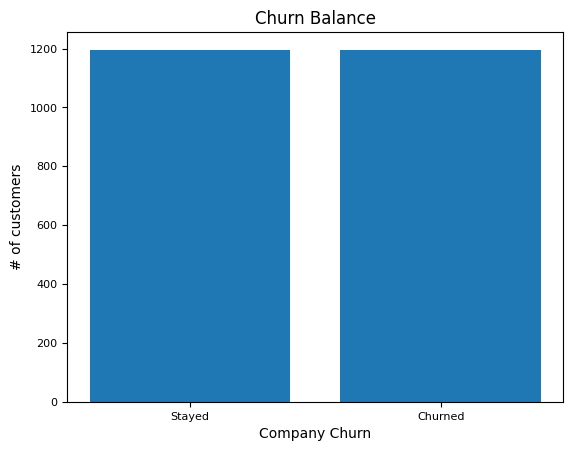

In [38]:
pipeline = Pipeline(
    steps=[
        ('preprocessing', scaled_preprocessor),
        ('undersample' , RandomUnderSampler(sampling_strategy = 1.0, random_state = 1) )
        ])

# test_resample = pipeline.fit(X_train, y_train)
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

show_feature_count(y_train_resampled)

### Optional SMOTE oversampling step

<span style='color:DarkBlue; font-size:large' > 
This will also eliminate the imbalance problem but will introduce 'fake' (but similar) data.
</span>

Churn Class 0 contains 3311 items  --- (50.000%)
Churn Class 1 contains 3311 items  --- (50.000%)


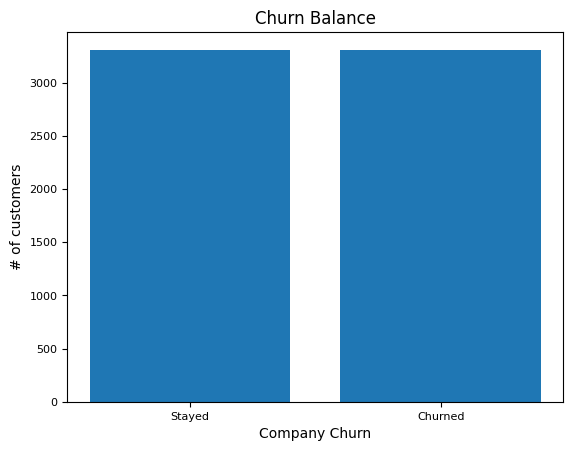

In [39]:
pipeline = Pipeline(
    steps=[
        ('preprocessing', scaled_preprocessor),
        ('smote' , SMOTE(sampling_strategy = 1.0, random_state = 1) )
        ])

# test_resample = pipeline.fit(X_train, y_train)
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

show_feature_count(y_train_resampled)

### Optional RandomUnder & SMOTE oversampling mixed step

<span style='color:DarkBlue; font-size:large' > 
This mixed resampling minimizes the problems of introducing fictional data and losing training data while fixing the imbalance.  This solution will be used if there appears to be too much overfitting occuring with CHURN and too much underfitting with the undersampled data.
</span>

Churn Class 0 contains 2392 items  --- (50.000%)
Churn Class 1 contains 2392 items  --- (50.000%)


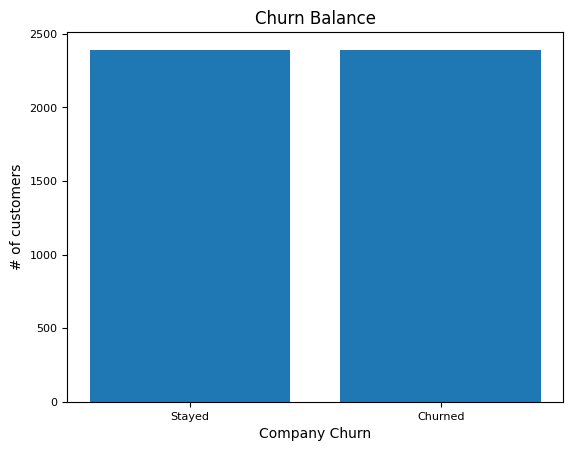

In [40]:
resample_mix = Pipeline(
        steps=[
        ('rand_under', RandomUnderSampler(sampling_strategy = 0.5, random_state = 1)),
        ('smote_over' , SMOTE(sampling_strategy = 1.0, random_state = 1))
        ])

pipeline = Pipeline(
    steps=[
        ('preprocessing', scaled_preprocessor),
        ('resample_mix' , resample_mix )
        ])

# test_resample = pipeline.fit(X_train, y_train)
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

show_feature_count(y_train_resampled)

# Model Evaluations
## PCA

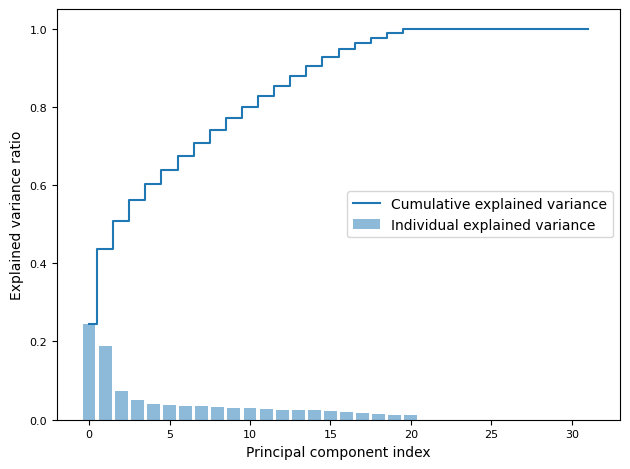

In [41]:
from sklearn.decomposition import PCA
pca = Pipeline(
    steps=[
        ('preprocessing', scaled_preprocessor),
        ('pca', PCA())
        ])
X_train_pca = pca.fit_transform(X_train)

estimator = pca.named_steps['pca']
explained_variance_ratio = estimator.explained_variance_ratio_

cumulation = np.cumsum(explained_variance_ratio)
plt.bar(range(0,len(explained_variance_ratio)), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cumulation)), cumulation, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

<span style='color:DarkBlue; font-size:large' >
    The PCA curve seems too gradual to be a significant help with eliminating a lot of dimensionality.  We might have better results using LDA.
</span>


## Linear Discriminant Analysis
### Quck check

In [42]:
from sklearn.metrics import f1_score
    
lda_lr_pipe = Pipeline(
    steps=[
        ('preprocessing', scaled_preprocessor),
        ('lda', LDA(n_components=None)),
        ('logreg', LogisticRegression( solver = "lbfgs", max_iter = 20000, random_state=1)),
        ])
    
scores = cross_val_score(estimator=lda_lr_pipe, X=X_train, y=y_train, scoring='roc_auc', cv=10, n_jobs=2)

print('ROC-AUC score for Logistic Regression with LDA: %.3f ' % (np.average(scores)))



ROC-AUC score for Logistic Regression with LDA: 0.846 


### Grid Search

In [43]:
# This takes too long to run for demo purposes.  If you want to run, uncomment the desired variables in the param_grid and take a look.

lda_lr_param_grid = {
     # 'preprocessing__numeric_transform_pipe__Imputer__strategy': ["mean", "median"],
     'logreg__penalty': ['l2'],                                                       # removed: 'l1','elasticnet', None
     'logreg__solver': ['lbfgs','liblinear'],  # removed: 'newton-cg', 'sag','saga','newton-cholesky'
     'logreg__max_iter': [5000],
     'logreg__class_weight': [ None],                                                 # removed 'balanced'
#      'logreg__tol': [0.0001, 0.001, 0.005],
#      'logreg__fit_intercept': [True, False],                                          # removed: False
#      'logreg__intercept_scaling': [0.20, .25, 0.30, 0.35],    
}  
    
lda_lr_pipe = Pipeline(
    steps=[
        ('preprocessing', scaled_preprocessor),
        ('undersample' , RandomUnderSampler(sampling_strategy = 1.0, random_state = 1) ),
        ('lda', LDA(n_components=None)),
        ('logreg', LogisticRegression( solver = "lbfgs", max_iter = 20000, random_state=1)),
        ])

lda_lr_grid_search = GridSearchCV(lda_lr_pipe, lda_lr_param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

lda_lr_grid_search.fit(X_train, y_train)

# print(lr_grid_search.get_params())

display_features = ['rank_test_score','mean_test_score','params']
search_results = pd.DataFrame(lda_lr_grid_search.cv_results_).loc[:,display_features].sort_values(by='rank_test_score', ascending=True)
display(search_results.head(5))


Fitting 5 folds for each of 2 candidates, totalling 10 fits


,rank_test_score,mean_test_score,params
0,1,0.849085,"{'logreg__class_weight': None, 'logreg__max_iter': 5000, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}"
1,1,0.849085,"{'logreg__class_weight': None, 'logreg__max_iter': 5000, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}"


### Best Grid Search results

These scores were found with cv=10.  

|mode| score | parameters |
|:--:|---|:---|
|unbalanced| 0.846288 | {'logreg__class_weight': 'balanced', 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.01, 'logreg__max_iter': 5000, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'logreg__tol': 0.001}|
|| 0.846288 | {'logreg__class_weight': None, 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.3, 'logreg__max_iter': 5000, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'logreg__tol': 0.01} |
|| 0.846288 | {'logreg__class_weight': None, 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.3, 'logreg__max_iter': 5000, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'logreg__tol': 0.1}|
|undersampled| 0.850497 | {'logreg__class_weight': None, 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.45, 'logreg__max_iter': 5000, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'logreg__tol': 0.005}|
|| 0.849979 | {'logreg__class_weight': None, 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.35, 'logreg__max_iter': 5000, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'logreg__tol': 0.001} |
|| 0.849598 | {'logreg__class_weight': None, 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.4, 'logreg__max_iter': 5000, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'logreg__tol': 0.001}|
|SMOTE| 0.846288 | {'logreg__class_weight': None, 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.05, 'logreg__max_iter': 5000, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'logreg__tol': 0.0001}|
|| 0.846288 | {'logreg__class_weight': None, 'logreg__fit_intercept': False, 'logreg__intercept_scaling': 0.2, 'logreg__max_iter': 5000, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cholesky', 'logreg__tol': 0.0001} |
|| 0.846288 | {'logreg__class_weight': None, 'logreg__fit_intercept': False, 'logreg__intercept_scaling': 0.2, 'logreg__max_iter': 5000, 'logreg__penalty': 'l2', 'logreg__solver': 'saga', 'logreg__tol': 0.005}|


## SelectFromModel (Random Forest)

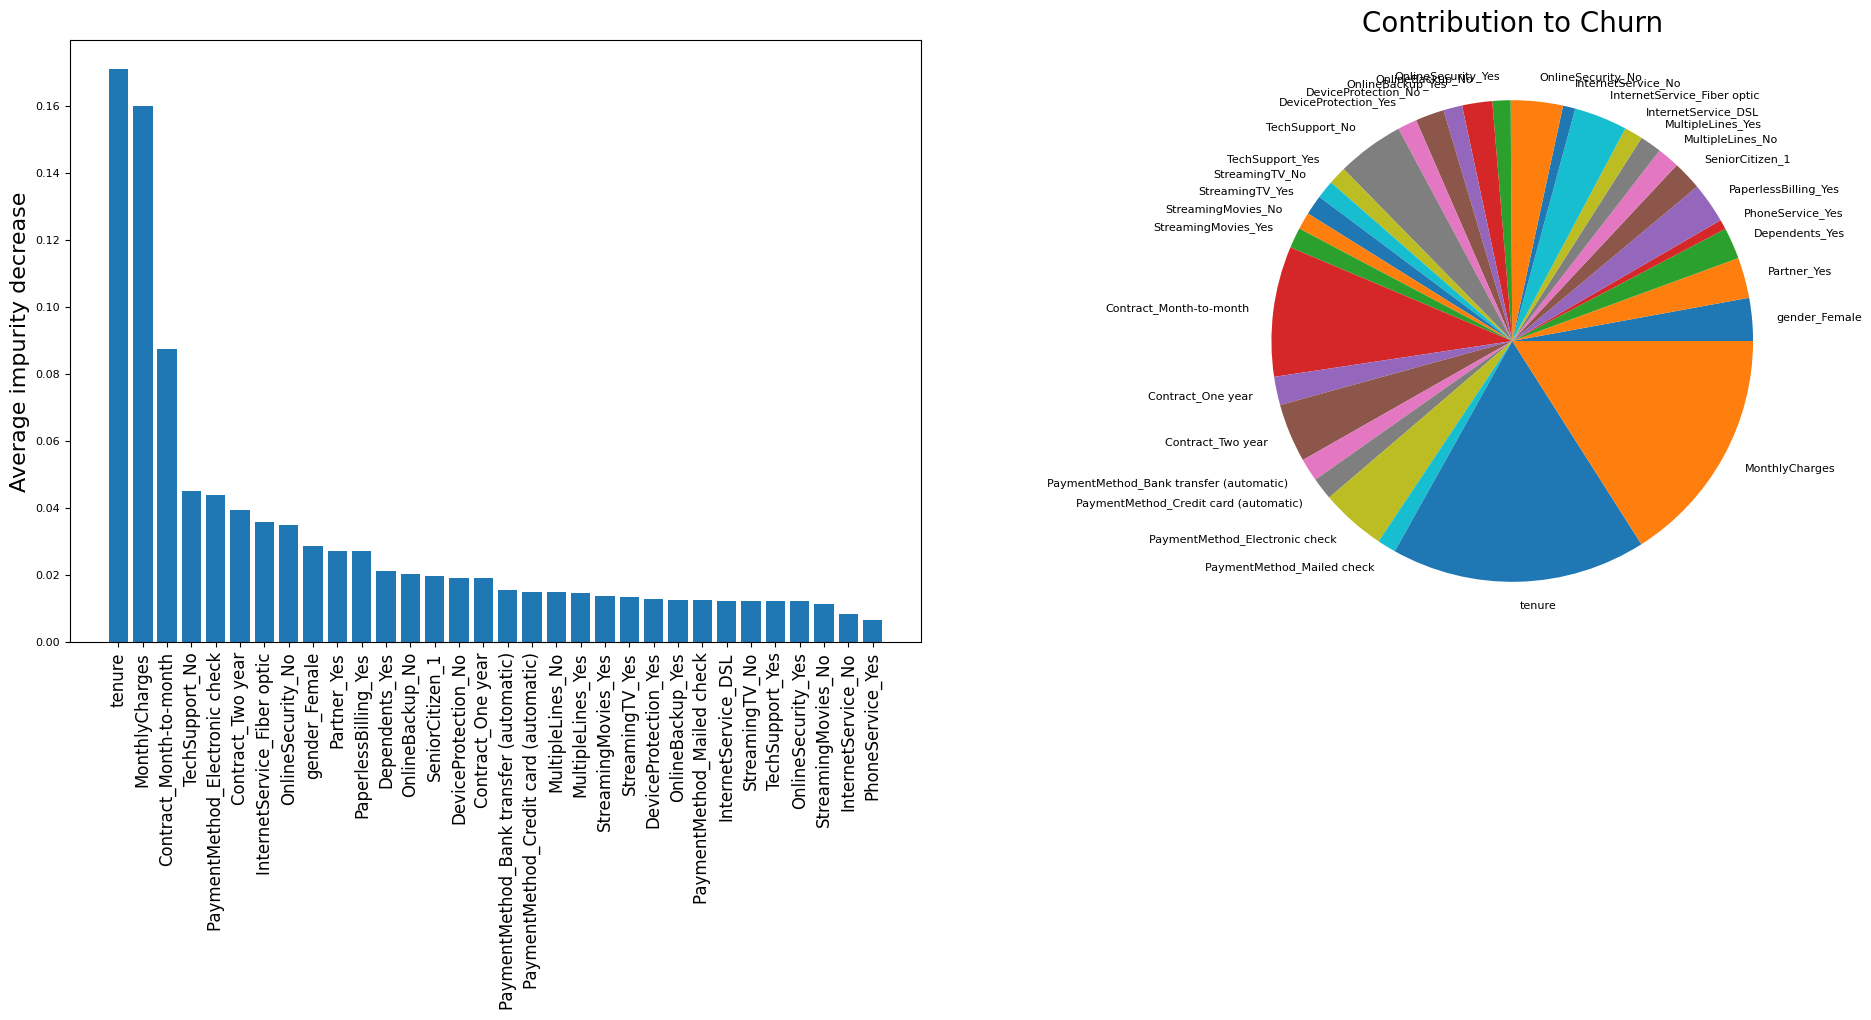

In [44]:
# This will take about 10 minutes
pie_plot_values = [None] * len(final_features)
pie_plot_names = [None] * len(final_features)

initial_forest_classifier = Pipeline(
    steps=[
        ('undersample' , RandomUnderSampler(random_state = 1) ),
        ('preprocessing', simple_preprocessor),
        ('estimator', RandomForestClassifier(random_state = 1))
        ])


initial_forest_classifier.fit(X_train, y_train)
estimator = initial_forest_classifier.named_steps['estimator']
random_forest_features = estimator.feature_names_in_
random_forest_importances = estimator.feature_importances_

data = list(zip(random_forest_features, random_forest_importances))
df_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
# print(df_importances)

indices = np.argsort(random_forest_importances)[::-1]
    
f, ax = plt.subplots(1, 2, figsize=(20, 10))   
ax[0].bar(range(len(random_forest_features)), random_forest_importances[indices], align='center')
ax[0].set_xticks(range(len(random_forest_features)))
ax[0].set_xticklabels(random_forest_features[indices],  rotation = 90,  fontsize=12)
ax[1].set_title("Contribution to Churn", fontsize=20)
ax[0].set_ylabel("Average impurity decrease", fontsize=16)
ax[1].pie(random_forest_importances, labels=random_forest_features)

f.tight_layout()
plt.show()


### SelectFromModel - threshold check 

In [45]:
select_threshold = 0.020

selector = Pipeline(
    steps=[
        ('preprocessing', simple_preprocessor),
        ('select', SelectFromModel( RandomForestClassifier(random_state = 1), threshold=select_threshold)),
        ])

narrow_df = selector.fit_transform(X_train, y_train)
display(narrow_df.head(3))


,gender_Female,Partner_Yes,Dependents_Yes,PaperlessBilling_Yes,SeniorCitizen_1,InternetService_Fiber optic,OnlineSecurity_No,OnlineBackup_No,TechSupport_No,Contract_Month-to-month,PaymentMethod_Electronic check,tenure,MonthlyCharges
2097,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,64.0,86.80
5378,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,5.0,80.10
768,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,40.0,42.35


## Logistic Regression
### Quick model check

In [46]:
scaled_lr_pipe = Pipeline(
    steps=[
        ('preprocessing', scaled_preprocessor),
        ('estimator', LogisticRegression( solver = "lbfgs", max_iter = 2000, random_state=1)),
        ])

scores = cross_val_score(estimator=scaled_lr_pipe, X=X_train, y=y_train, scoring='roc_auc', cv=3, n_jobs=2)

print('ROC-AUC scores: ', scores)

ROC-AUC scores:  [0.84597703 0.85631054 0.85077381]


### Feature selection for Logistic Regression

In [47]:
for max_features in [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 18, 22, 26, 31]:
    selector = Pipeline(
        steps=[
            ('preprocessing', simple_preprocessor),
            ('select', SelectFromModel( RandomForestClassifier(random_state = 1), max_features=max_features)),
            ('estimator', LogisticRegression( solver = "lbfgs", penalty='l2', max_iter = 20000, random_state=1)),
            ])

    scores = cross_val_score(estimator=selector, X=X_train, y=y_train, scoring='roc_auc', cv=5, n_jobs=2)

    print('ROC-AUC scores with top %d features: %.3f' %  (max_features,np.average(scores)))

ROC-AUC scores with top 1 features: 0.737
ROC-AUC scores with top 2 features: 0.813
ROC-AUC scores with top 3 features: 0.833
ROC-AUC scores with top 4 features: 0.837
ROC-AUC scores with top 5 features: 0.839
ROC-AUC scores with top 6 features: 0.843
ROC-AUC scores with top 7 features: 0.845
ROC-AUC scores with top 8 features: 0.845
ROC-AUC scores with top 10 features: 0.845
ROC-AUC scores with top 12 features: 0.845
ROC-AUC scores with top 15 features: 0.845
ROC-AUC scores with top 18 features: 0.845
ROC-AUC scores with top 22 features: 0.845
ROC-AUC scores with top 26 features: 0.845
ROC-AUC scores with top 31 features: 0.845


### Logistic Regression GridSearch 

In [48]:
# This takes too long to run for demo purposes.  If you want to run, uncomment the desired variables in the param_grid and take a look.

lr_param_grid = {
#      'preprocessing__numeric_transform_pipe__Imputer__strategy': ["mean", "median"],
       'logreg__penalty': ['l2'],                                        # removed: 'l1','elasticnet', 'l2', None
       'logreg__solver': ['lbfgs','liblinear'],   # removed: 'sag','saga','liblinear','newton-cg','newton-cholesky'
       'logreg__max_iter': [10000],
       'logreg__class_weight': [None],                                  # Removed: 'balanced', 
#        'logreg__C': [0.65, 1.0, 2.0, 10.0],                        # only with penalty
#        'logreg__tol': [0.005, 0.01, 0.5],
#        'logreg__fit_intercept': [True],                                                   # remove: False
#        'logreg__intercept_scaling': [0.1, 0.3, 0.6],
}  
    
lr_pipe = Pipeline(
        steps=[
            ('preprocessing', simple_preprocessor),
            ('smote' , SMOTE(sampling_strategy = 1.0, random_state = 1) ),
            ('logreg', LogisticRegression(random_state=1)),
            ])

lr_grid_search = GridSearchCV(lr_pipe, lr_param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

lr_grid_search.fit(X_train, y_train)

# print(lr_grid_search.get_params())

display_features = ['rank_test_score','mean_test_score','params']
search_results = pd.DataFrame(lr_grid_search.cv_results_).loc[:,display_features].sort_values(by='rank_test_score', ascending=True)
display(search_results.head(5))


Fitting 5 folds for each of 2 candidates, totalling 10 fits


,rank_test_score,mean_test_score,params
0,1,0.848442,"{'logreg__class_weight': None, 'logreg__max_iter': 10000, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}"
1,2,0.848288,"{'logreg__class_weight': None, 'logreg__max_iter': 10000, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}"


### Best Grid Search results

These scores were found with cv=10.  (Without select)  

|mode| score | parameters |
|:--:|---|:---|
|unbalanced| 0.850186 | {'logreg__C': 0.69, 'logreg__class_weight': 'balanced', 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.5, 'logreg__max_iter': 10000, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'logreg__tol': 0.005}|
|| 0.850186 | {'logreg__C': 0.69, 'logreg__class_weight': 'balanced', 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.8, 'logreg__max_iter': 10000, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'logreg__tol': 0.15} |
|| 0.850186 | {'logreg__C': 0.69, 'logreg__class_weight': 'balanced', 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.8, 'logreg__max_iter': 10000, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'logreg__tol': 0.05}|
|undersampled| 0.851763 | {'logreg__C': 0.3, 'logreg__class_weight': None, 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.6, 'logreg__max_iter': 10000, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'logreg__tol': 0.001}|
|| 0.851689 | {'logreg__C': 0.07, 'logreg__class_weight': None, 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.7, 'logreg__max_iter': 10000, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg', 'logreg__tol': 0.005} |
|| 0.851685 | {'logreg__C': 0.1, 'logreg__class_weight': None, 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.8, 'logreg__max_iter': 10000, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'logreg__tol': 0.001}|
|SMOTE| 0.848681 | {'logreg__C': 0.65, 'logreg__class_weight': None, 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.75, 'logreg__max_iter': 10000, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'logreg__tol': 0.005}|
|| 0.848681 | {'logreg__C': 0.65, 'logreg__class_weight': None, 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.7, 'logreg__max_iter': 10000, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'logreg__tol': 0.005} |
|| 0.848681 | {'logreg__C': 0.65, 'logreg__class_weight': None, 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 0.7, 'logreg__max_iter': 10000, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'logreg__tol': 0.01}|



## Support Vector Machine Classifier
### Quick check

In [49]:
from sklearn.svm import SVC

for max_features in [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 18, 22, 26, 31]:
    svc_pipe = Pipeline(
        steps=[
            ('preprocessing', scaled_preprocessor),
            ('select', SelectFromModel( RandomForestClassifier(random_state = 1), max_features=max_features)),
            ('estimator',SVC(kernel='linear', C = 4, gamma = 'scale', random_state=1)),
            ])
    #‘linear’, ‘sigmoid’

    scores = cross_val_score(estimator=svc_pipe, X=X_train, y=y_train, scoring='roc_auc', cv=5, n_jobs=2)

    print('ROC-AUC score for SVM with top %d features: : %.3f' % (max_features,np.average(scores)))

ROC-AUC score for SVM with top 1 features: : 0.717
ROC-AUC score for SVM with top 2 features: : 0.813
ROC-AUC score for SVM with top 3 features: : 0.829
ROC-AUC score for SVM with top 4 features: : 0.834
ROC-AUC score for SVM with top 5 features: : 0.838
ROC-AUC score for SVM with top 6 features: : 0.840
ROC-AUC score for SVM with top 7 features: : 0.841
ROC-AUC score for SVM with top 8 features: : 0.841
ROC-AUC score for SVM with top 10 features: : 0.841
ROC-AUC score for SVM with top 12 features: : 0.841
ROC-AUC score for SVM with top 15 features: : 0.841
ROC-AUC score for SVM with top 18 features: : 0.841
ROC-AUC score for SVM with top 22 features: : 0.841
ROC-AUC score for SVM with top 26 features: : 0.841
ROC-AUC score for SVM with top 31 features: : 0.841


### SVC Grid Search

In [50]:
# This takes too long to run for demo purposes.  If you want to run, uncomment the desired variables in the param_grid and take a look.

svc_param_grid = {
#    'preprocessing__numeric_transform_pipe__Imputer__strategy': ["mean", "median"],
#     'select__estimator__n_estimators':[200],
#     'select__max_features' : [18,19,20,21],
    'svc__kernel': ['sigmoid' ],                                                       # Removed: poly', 'rbf', 'sigmoid'
    'svc__C': [0.001, 0.005, 0.009, 0.010,0.013, 0.015],                                                                   # Removed: 3, 5
    'svc__gamma': ['scale'],                                                     # Removed: 'scale', 'auto'
    'svc__class_weight': [None],                                               # Removed: 'balanced', 

    }      
    
svc_pipe = Pipeline(
    steps=[
        ('preprocessing', scaled_preprocessor),
        ('undersample' , RandomUnderSampler(sampling_strategy = 1.0, random_state = 1) ),
#         ('select', SelectFromModel( RandomForestClassifier(random_state = 1))),
        ('svc',SVC(random_state=1)),
        ])

svc_grid_search = GridSearchCV(svc_pipe, svc_param_grid, cv=5, scoring='roc_auc', verbose=1,n_jobs=-1)

svc_grid_search.fit(X_train, y_train)

display_features = ['rank_test_score','mean_test_score','params']
search_results = pd.DataFrame(svc_grid_search.cv_results_).loc[:,display_features].sort_values(by='rank_test_score', ascending=True)
display(search_results.head(5))


Fitting 5 folds for each of 6 candidates, totalling 30 fits


,rank_test_score,mean_test_score,params
0,1,0.846757,"{'svc__C': 0.001, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__kernel': 'sigmoid'}"
3,2,0.846704,"{'svc__C': 0.01, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__kernel': 'sigmoid'}"
5,3,0.846692,"{'svc__C': 0.015, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__kernel': 'sigmoid'}"
1,4,0.846675,"{'svc__C': 0.005, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__kernel': 'sigmoid'}"
2,5,0.846624,"{'svc__C': 0.009, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__kernel': 'sigmoid'}"


### Best Grid Search results

These scores were found with cv=2.  

|mode| score | parameters |
|:--:|---|:---:|
|unbalanced| 0.843848 | {'select__estimator__n_estimators': 200, 'select__max_features': 20, 'svc__C': 4, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'linear'} |
|| 0.843848 | {'select__estimator__n_estimators': 200, 'select__max_features': 25, 'svc__C': 4, 'svc__class_weight': 'balanced', 'svc__gamma': 'auto', 'svc__kernel': 'linear'} |
|| 0.843848 | {'select__estimator__n_estimators': 200, 'select__max_features': 25, 'svc__C': 4, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'linear'} |
|undersampled| 0.848109 | {'select__estimator__n_estimators': 200, 'select__max_features': 20, 'svc__C': 0.028, 'svc__class_weight': None, 'svc__gamma': 'auto', 'svc__kernel': 'linear'}|
|| 0.847970 | {'select__estimator__n_estimators': 200, 'select__max_features': 19, 'svc__C': 0.029, 'svc__class_weight': None, 'svc__gamma': 'auto', 'svc__kernel': 'linear'}|
|| 0.847950 | {'select__estimator__n_estimators': 200, 'select__max_features': 18, 'svc__C': 0.035, 'svc__class_weight': None, 'svc__gamma': 'auto', 'svc__kernel': 'linear'}|
|SMOTE| 0.848210 | {'svc__C': 0.01, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__kernel': 'sigmoid'}|
|| 0.848119 | {'svc__C': 0.009, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__kernel': 'sigmoid'}|
|| 0.847894 | {'svc__C': 0.013, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__kernel': 'sigmoid'}|


## Decision Tree
### Quick check

In [51]:
from sklearn.tree import DecisionTreeClassifier

# max_features = len(final_features)
# print(final_features)
for impurity_measure in ['entropy','gini']:
    print()
    for max_depth in range(3,12):
        dt_pipe = Pipeline(
            steps=[
                ('preprocessing', simple_preprocessor),
                ('decisiontree',DecisionTreeClassifier(criterion = impurity_measure, max_depth=max_depth, random_state = 1)),
                ])
        dt_pipe.fit(X_train, y_train)
        scores = cross_val_score(estimator=dt_pipe, X=X_train, y=y_train, scoring='roc_auc', cv=5, n_jobs=2)

        print('[%s] ROC-AUC score for Decision Tree at %d levels deep: %.3f ' % (impurity_measure,max_depth, np.average(scores)))


[entropy] ROC-AUC score for Decision Tree at 3 levels deep: 0.819 
[entropy] ROC-AUC score for Decision Tree at 4 levels deep: 0.834 
[entropy] ROC-AUC score for Decision Tree at 5 levels deep: 0.826 
[entropy] ROC-AUC score for Decision Tree at 6 levels deep: 0.824 
[entropy] ROC-AUC score for Decision Tree at 7 levels deep: 0.808 
[entropy] ROC-AUC score for Decision Tree at 8 levels deep: 0.794 
[entropy] ROC-AUC score for Decision Tree at 9 levels deep: 0.775 
[entropy] ROC-AUC score for Decision Tree at 10 levels deep: 0.754 
[entropy] ROC-AUC score for Decision Tree at 11 levels deep: 0.726 

[gini] ROC-AUC score for Decision Tree at 3 levels deep: 0.819 
[gini] ROC-AUC score for Decision Tree at 4 levels deep: 0.834 
[gini] ROC-AUC score for Decision Tree at 5 levels deep: 0.832 
[gini] ROC-AUC score for Decision Tree at 6 levels deep: 0.823 
[gini] ROC-AUC score for Decision Tree at 7 levels deep: 0.811 
[gini] ROC-AUC score for Decision Tree at 8 levels deep: 0.784 
[gini] RO

### Decision Tree Grid Search

In [52]:
# This takes too long to run for demo purposes.  If you want to run, uncomment the desired variables in the param_grid and take a look.

dt_param_grid = {
#     'preprocessing__numeric_transform_pipe__Imputer__strategy': ["mean", "median"],
#     'select__estimator__n_estimators':[200],
#     'select__max_features' : [18,19,20,21],
    'decisiontree__criterion': ['gini','entropy'],                                     # -gini
    'decisiontree__max_depth': range(3, 8),
}      
    
dt_pipe = Pipeline(
    steps=[
        ('preprocessing', simple_preprocessor),
        ('select', SelectFromModel( RandomForestClassifier(random_state = 1))),
        ('undersample' , RandomUnderSampler(sampling_strategy = 1.0, random_state = 1) ),
        ('decisiontree',DecisionTreeClassifier(random_state = 1)),
        ])

dt_grid_search = GridSearchCV(dt_pipe, dt_param_grid, cv=10, scoring='roc_auc', verbose=1,n_jobs=-1)

dt_grid_search.fit(X_train, y_train)

display_features = ['rank_test_score','mean_test_score','params']
search_results = pd.DataFrame(dt_grid_search.cv_results_).loc[:,display_features].sort_values(by='rank_test_score', ascending=True)
display(search_results.head(5))


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,rank_test_score,mean_test_score,params
7,1,0.830449,"{'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 5}"
2,2,0.826326,"{'decisiontree__criterion': 'gini', 'decisiontree__max_depth': 5}"
6,3,0.824049,"{'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 4}"
1,4,0.822082,"{'decisiontree__criterion': 'gini', 'decisiontree__max_depth': 4}"
8,5,0.820692,"{'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 6}"


### Best Grid Search results

These scores were found with cv=10 

|mode| score | parameters |
|:--:|---|:---:|
|unbalanced| 0.835334 | {'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 4, 'preprocessing__numeric_transform_pipe__Imputer__strategy': 'mean'} |
|| 0.835334 | {'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 4, 'preprocessing__numeric_transform_pipe__Imputer__strategy': 'median'} |
|| 0.832962 | {'decisiontree__criterion': 'gini', 'decisiontree__max_depth': 4, 'preprocessing__numeric_transform_pipe__Imputer__strategy': 'mean'} |
|undersampled| 0.833730 | {'decisiontree__criterion': 'gini', 'decisiontree__max_depth': 5, 'preprocessing__numeric_transform_pipe__Imputer__strategy': 'mean'}|
|| 0.833476 | {'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 4, 'preprocessing__numeric_transform_pipe__Imputer__strategy': 'median'}|
|| 0.832481 | {'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 4, 'preprocessing__numeric_transform_pipe__Imputer__strategy': 'mean'}|
|SMOTE| 0.824771 | {'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 7, 'select__estimator__n_estimators': 200, 'select__max_features': 21}|
|| 0.824771 | {'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 7, 'select__estimator__n_estimators': 200, 'select__max_features': 19}|
|| 0.824771 | {'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 7, 'select__estimator__n_estimators': 200, 'select__max_features': 18}|



### Decision Tree View

I thought it strange the StreamingMovies, PaymentMethod and MultipleLines were the first splits when they appeared relatively low on the Feature Selection list.

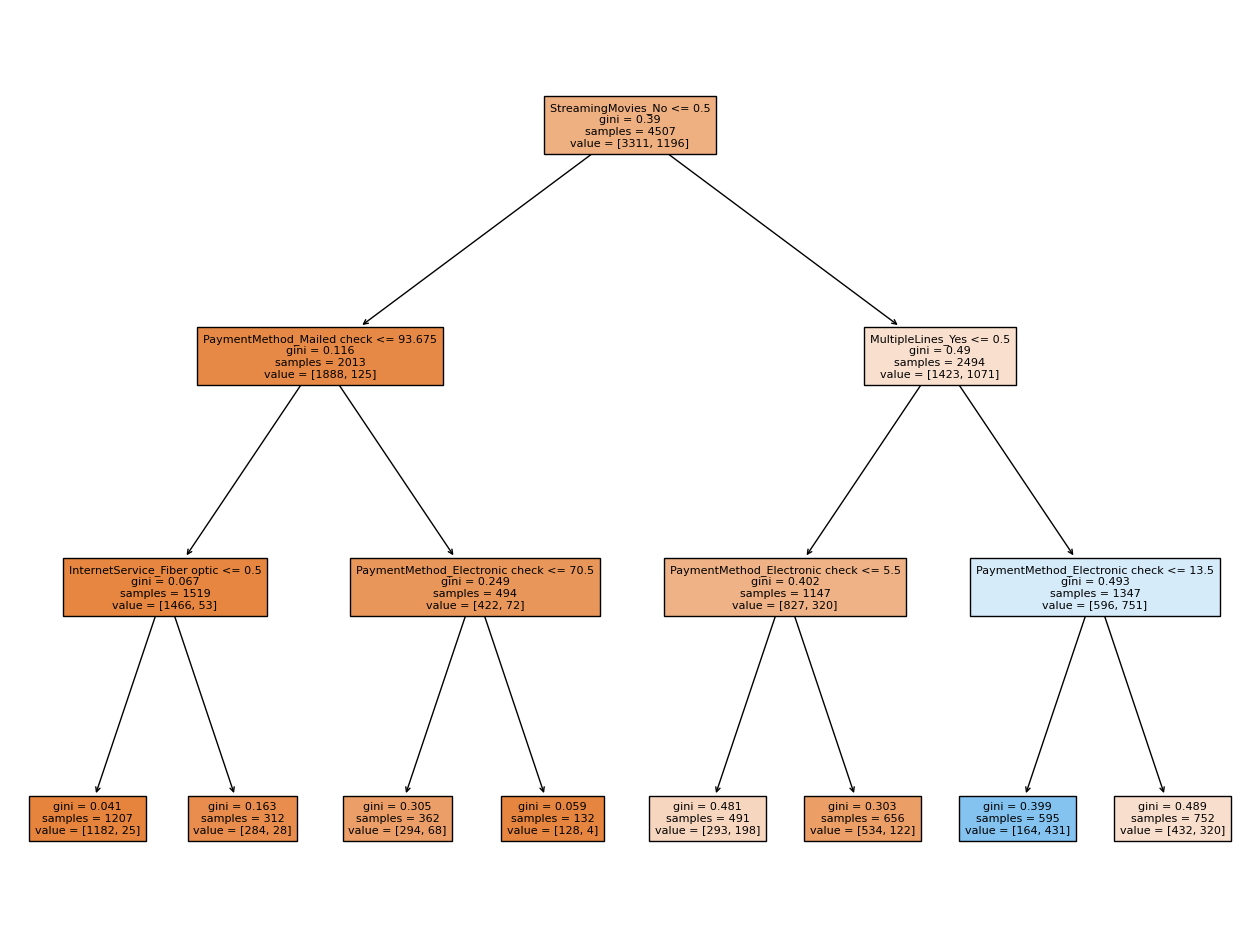

In [53]:
from sklearn import tree
dt_pipe = Pipeline(
    steps=[
        ('preprocessing', simple_preprocessor),

        ('decisiontree',DecisionTreeClassifier(criterion = 'gini', max_depth=3, random_state = 1)),
        ])
dt_pipe.fit(X_train, y_train)
tree_in_pipe = dt_pipe.named_steps['decisiontree']
plt.figure(figsize=(16,12))  # set plot size (denoted in inches)
tree.plot_tree(tree_in_pipe, feature_names=final_features, filled = True, fontsize=8)
#feature_names=features_names, class_names=target_names
plt.show()

## Random Forest Classifier
### Quick check

In [54]:
import math
from sklearn.ensemble import RandomForestClassifier
n_features = len(final_features)
sqrt_n_features = round(math.sqrt(len(final_features)))
for max_features in range(1,n_features,sqrt_n_features):
    rf_pipe = Pipeline(
        steps=[
            ('preprocessing', simple_preprocessor),
            
            ('randomforest',RandomForestClassifier( n_estimators = 500, criterion = "entropy", max_features = max_features,n_jobs = -1, random_state = 1)),
            ])

    rf_pipe.fit(X_train, y_train)
    y_pred = rf_pipe.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print('Accuracy score for %d max_features: %.3f ' % (max_features, score))
    
    scores = cross_val_score(estimator=rf_pipe, X=X_train, y=y_train, scoring='roc_auc', cv=5, n_jobs=2)
    print('ROC-AUC score for Random Forest choosing %d features max: %.3f ' % (max_features, np.average(scores)))


Accuracy score for 1 max_features: 0.768 
ROC-AUC score for Random Forest choosing 1 features max: 0.816 
Accuracy score for 7 max_features: 0.771 
ROC-AUC score for Random Forest choosing 7 features max: 0.828 
Accuracy score for 13 max_features: 0.771 
ROC-AUC score for Random Forest choosing 13 features max: 0.828 
Accuracy score for 19 max_features: 0.770 
ROC-AUC score for Random Forest choosing 19 features max: 0.829 
Accuracy score for 25 max_features: 0.768 
ROC-AUC score for Random Forest choosing 25 features max: 0.826 
Accuracy score for 31 max_features: 0.764 
ROC-AUC score for Random Forest choosing 31 features max: 0.827 


### Random Forest Grid Search

In [55]:
# This takes too long to run for demo purposes.  If you want to run, uncomment the desired variables in the param_grid and take a look. 

# n_features = len(final_features)
# sqrt_n_features = round(math.sqrt(len(final_features)))

rf_param_grid = {
#   'preprocessing__numeric_transform_pipe__Imputer__strategy': ["mean", "median"],
    'randomforest__n_estimators': [2000],
    'randomforest__criterion': ['entropy'],                                         # Removed: gini
    'randomforest__max_features': [None],                                             # Removed: 
    'randomforest__class_weight': [None],                                     # Remove: None, 'balanced'
    'randomforest__max_depth' : np.arange(2,5,1),
#     'select__estimator__n_estimators':[200, 300, 500],
#     'select__max_features' : range(25,n_features,1),
}  
    
rf_pipe = Pipeline(
    steps=[
        ('preprocessing', simple_preprocessor),
        ('undersample' , RandomUnderSampler(sampling_strategy = 1.0, random_state = 1) ),
        ('select', SelectFromModel( RandomForestClassifier(random_state = 1), max_features=None)),
        ('randomforest',RandomForestClassifier(n_jobs = -1, random_state = 1)),
        ])

rf_grid_search = GridSearchCV(rf_pipe, rf_param_grid, cv=5, scoring='roc_auc', verbose=1,n_jobs=-1)

rf_grid_search.fit(X_train, y_train)

display_features = ['rank_test_score','mean_test_score','params']
search_results = pd.DataFrame(rf_grid_search.cv_results_).loc[:,display_features].sort_values(by='rank_test_score', ascending=True)
display(search_results.head(5))



Fitting 5 folds for each of 3 candidates, totalling 15 fits


,rank_test_score,mean_test_score,params
2,1,0.846215,"{'randomforest__class_weight': None, 'randomforest__criterion': 'entropy', 'randomforest__max_depth': 4, 'randomforest__max_features': None, 'randomforest__n_estimators': 2000}"
1,2,0.838880,"{'randomforest__class_weight': None, 'randomforest__criterion': 'entropy', 'randomforest__max_depth': 3, 'randomforest__max_features': None, 'randomforest__n_estimators': 2000}"
0,3,0.830464,"{'randomforest__class_weight': None, 'randomforest__criterion': 'entropy', 'randomforest__max_depth': 2, 'randomforest__max_features': None, 'randomforest__n_estimators': 2000}"


### Best Grid Search results

These scores were found with cv=3 

|mode| score | parameters |
|:--:|---|:---|
|unbalanced| 0.84718 | {'randomforest__class_weight': 'balanced', 'randomforest__criterion': 'entropy', 'randomforest__max_depth': 4, 'randomforest__max_features': None, 'randomforest__n_estimators': 2000, 'select__estimator__n_estimators': 500, 'select__max_features': 32} |
|| 0.84718 | {'randomforest__class_weight': 'balanced', 'randomforest__criterion': 'entropy', 'randomforest__max_depth': 4, 'randomforest__max_features': None, 'randomforest__n_estimators': 2000, 'select__estimator__n_estimators': 500, 'select__max_features': 16} |
|| 0.84718 |{'randomforest__class_weight': 'balanced', 'randomforest__criterion': 'entropy', 'randomforest__max_depth': 4, 'randomforest__max_features': None, 'randomforest__n_estimators': 2000, 'select__estimator__n_estimators': 500, 'select__max_features': 17} |
|undersampled|0.849366 | {'randomforest__class_weight': None, 'randomforest__criterion': 'entropy', 'randomforest__max_depth': 4, 'randomforest__max_features': None, 'randomforest__n_estimators': 2000}|
|| 0.848696 | {'randomforest__class_weight': None, 'randomforest__criterion': 'gini', 'randomforest__max_depth': 4, 'randomforest__max_features': None, 'randomforest__n_estimators': 2000}|
|| 0.846795 | {'randomforest__class_weight': 'balanced', 'randomforest__criterion': 'entropy', 'randomforest__max_depth': 4, 'randomforest__max_features': None, 'randomforest__n_estimators': 2000}|
|SMOTE|0.833491 | {'randomforest__class_weight': None, 'randomforest__criterion': 'entropy', 'randomforest__max_depth': 4, 'randomforest__max_features': None, 'randomforest__n_estimators': 2000, 'select__estimator__n_estimators': 500, 'select__max_features': 32}|
||0.833491 | {'randomforest__class_weight': None, 'randomforest__criterion': 'entropy', 'randomforest__max_depth': 4, 'randomforest__max_features': None, 'randomforest__n_estimators': 2000, 'select__estimator__n_estimators': 300, 'select__max_features': 27}|
|| 0.833491 | {'randomforest__class_weight': None, 'randomforest__criterion': 'entropy', 'randomforest__max_depth': 4, 'randomforest__max_features': None, 'randomforest__n_estimators': 2000, 'select__estimator__n_estimators': 300, 'select__max_features': 28}|



## Random Forest - Random Search

In [56]:
# This takes too long to run for demo purposes.  If you want to run, uncomment the desired variables in the param_grid and take a look. 

rf_param = {
#     'randomforest__n_estimators': [2000, 3000],
#     'randomforest__criterion': ['entropy', 'gini'],
    'randomforest__max_depth' : np.arange(2,7,1),
    'randomforest__max_features': ['sqrt','log2',None],                         # Removed: 'log2', None
    'randomforest__class_weight': [None],                                       # Removed: 'balanced'            
#     'select__estimator__n_estimators':[400, 500, 700],
#     'select__max_features' : range(6,len(final_features),1),
}  

rf_pipe = Pipeline(
    steps=[
        ('preprocessing', simple_preprocessor),
        ('undersample' , RandomUnderSampler(sampling_strategy = 1.0, random_state = 1) ),
#         ('select', SelectFromModel( RandomForestClassifier(random_state = 1))),
        ('randomforest',RandomForestClassifier(n_jobs = -1, random_state = 1)),
        ])

rf_random_search = RandomizedSearchCV(rf_pipe, rf_param, cv=5, scoring='roc_auc', n_iter=30, return_train_score=False, random_state = 1)

rf_random_search.fit(X_train, y_train)

display_features = ['rank_test_score','mean_test_score','params']
search_results = pd.DataFrame(rf_random_search.cv_results_).loc[:,display_features].sort_values(by='rank_test_score', ascending=True)
display(search_results.head(5))



/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 15 is smaller than n_iter=30. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,rank_test_score,mean_test_score,params
11,1,0.849524,"{'randomforest__max_features': None, 'randomforest__max_depth': 5, 'randomforest__class_weight': None}"
8,2,0.848412,"{'randomforest__max_features': None, 'randomforest__max_depth': 4, 'randomforest__class_weight': None}"
14,3,0.848237,"{'randomforest__max_features': None, 'randomforest__max_depth': 6, 'randomforest__class_weight': None}"
12,4,0.847583,"{'randomforest__max_features': 'sqrt', 'randomforest__max_depth': 6, 'randomforest__class_weight': None}"
13,4,0.847583,"{'randomforest__max_features': 'log2', 'randomforest__max_depth': 6, 'randomforest__class_weight': None}"


|mode| score | parameters |
|:--:|---|:---:|
|unbalanced|0.850104 | {'randomforest__n_estimators': 2000, 'randomforest__max_features': None, 'randomforest__max_depth': 5, 'randomforest__criterion': 'gini', 'randomforest__class_weight': 'balanced'} |
|| 0.849800 | {'randomforest__n_estimators': 2000, 'randomforest__max_features': None, 'randomforest__max_depth': 6, 'randomforest__criterion': 'gini', 'randomforest__class_weight': None}|
|| 0.849407 |{'randomforest__n_estimators': 2000, 'randomforest__max_features': None, 'randomforest__max_depth': 4, 'randomforest__criterion': 'entropy', 'randomforest__class_weight': 'balanced'} |
|undersampled|0.852140 | {'randomforest__n_estimators': 1000, 'randomforest__max_features': None, 'randomforest__max_depth': 5, 'randomforest__criterion': 'gini', 'randomforest__class_weight': None}|
|| 0.850041 | {'randomforest__n_estimators': 1000, 'randomforest__max_features': 'sqrt', 'randomforest__max_depth': 6, 'randomforest__criterion': 'entropy', 'randomforest__class_weight': None}|
|| 0.849450 | {'randomforest__n_estimators': 1000, 'randomforest__max_features': None, 'randomforest__max_depth': 4, 'randomforest__criterion': 'gini', 'randomforest__class_weight': None}|
|SMOTE|0.846267 | {'randomforest__n_estimators': 3000, 'randomforest__max_features': 'log2', 'randomforest__max_depth': 6, 'randomforest__criterion': 'entropy', 'randomforest__class_weight': None}|
|| 0.846146 | {'randomforest__n_estimators': 2000, 'randomforest__max_features': 'log2', 'randomforest__max_depth': 6, 'randomforest__criterion': 'entropy', 'randomforest__class_weight': None}|
|| 0.846146 | {'randomforest__n_estimators': 2000, 'randomforest__max_features': 'sqrt', 'randomforest__max_depth': 6, 'randomforest__criterion': 'entropy', 'randomforest__class_weight': None}|


## K Nearest Neighbors
### Quick check

In [57]:
for neighbors in range(1,30,2):
    knn_pipe = Pipeline(steps=[
        ('preprocessing', scaled_preprocessor),
        ('estimator',KNeighborsClassifier(metric = 'minkowski', p=2, n_neighbors = neighbors)),
        ],
    verbose = False)

    knn_pipe.fit(X_train, y_train)
    scores = cross_val_score(estimator=knn_pipe, X=X_train, y=y_train, scoring='roc_auc', cv=10, n_jobs=2)

    print('ROC-AUC score for KNN with %d neighbors: %.3f ' % (neighbors, np.average(scores)))

ROC-AUC score for KNN with 1 neighbors: 0.652 
ROC-AUC score for KNN with 3 neighbors: 0.757 
ROC-AUC score for KNN with 5 neighbors: 0.789 
ROC-AUC score for KNN with 7 neighbors: 0.806 
ROC-AUC score for KNN with 9 neighbors: 0.816 
ROC-AUC score for KNN with 11 neighbors: 0.820 
ROC-AUC score for KNN with 13 neighbors: 0.824 
ROC-AUC score for KNN with 15 neighbors: 0.828 
ROC-AUC score for KNN with 17 neighbors: 0.831 
ROC-AUC score for KNN with 19 neighbors: 0.834 
ROC-AUC score for KNN with 21 neighbors: 0.835 
ROC-AUC score for KNN with 23 neighbors: 0.836 
ROC-AUC score for KNN with 25 neighbors: 0.836 
ROC-AUC score for KNN with 27 neighbors: 0.836 
ROC-AUC score for KNN with 29 neighbors: 0.836 


### KNN Grid Search

In [58]:
# This takes too long to run for demo purposes.  If you want to run, uncomment the desired variables in the param_grid and take a look.

knn_param_grid = {
#     'preprocessing__numeric_transform_pipe__Imputer__strategy': ["mean", "median"],
    'select__estimator__n_estimators':[200],
#     'select__max_features' : range(3,len(final_features),1),
#     'select__max_features' : range(4,8,1),
#     'estimator__n_neighbors': [ 58, 59, 60, 61, 62],
    'estimator__metric': ['minkowski'],
    'estimator__p': [1, 2],                                                     # Removed: 2
    'estimator__weights': ['uniform', 'distance'],

}

knn_pipe = Pipeline(steps=[
    ('preprocessing', scaled_preprocessor),
    ('undersample' , RandomUnderSampler(sampling_strategy = 1.0, random_state = 1) ),
    ('select', SelectFromModel( RandomForestClassifier(random_state = 1))),
    ('estimator',KNeighborsClassifier()),
    ],
    verbose = False)

knn_grid_search = GridSearchCV(knn_pipe, knn_param_grid, cv=2, scoring='roc_auc', verbose=1,n_jobs=-1)

knn_grid_search.fit(X_train, y_train)

display_features = ['rank_test_score','mean_test_score','params']
search_results = pd.DataFrame(knn_grid_search.cv_results_).loc[:,display_features].sort_values(by='rank_test_score', ascending=True)
display(search_results.head(5))


Fitting 2 folds for each of 4 candidates, totalling 8 fits


,rank_test_score,mean_test_score,params
0,1,0.802344,"{'estimator__metric': 'minkowski', 'estimator__p': 1, 'estimator__weights': 'uniform', 'select__estimator__n_estimators': 200}"
2,2,0.799224,"{'estimator__metric': 'minkowski', 'estimator__p': 2, 'estimator__weights': 'uniform', 'select__estimator__n_estimators': 200}"
1,3,0.788602,"{'estimator__metric': 'minkowski', 'estimator__p': 1, 'estimator__weights': 'distance', 'select__estimator__n_estimators': 200}"
3,4,0.787026,"{'estimator__metric': 'minkowski', 'estimator__p': 2, 'estimator__weights': 'distance', 'select__estimator__n_estimators': 200}"


### Best Grid Search results

These scores were found with cv=10.  

|mode| score | parameters |
|:--:|---|:---:|
|unbalanced| 0.844633 | {'estimator__metric': 'minkowski', 'estimator__n_neighbors': 61, 'estimator__p': 1, 'estimator__weights': 'uniform', 'select__estimator__n_estimators': 200, 'select__max_features': 7} |
|| 0.844280 | {'estimator__metric': 'minkowski', 'estimator__n_neighbors': 60, 'estimator__p': 1, 'estimator__weights': 'uniform', 'select__estimator__n_estimators': 200, 'select__max_features': 7} |
|| 0.844103 | {'estimator__metric': 'minkowski', 'estimator__n_neighbors': 119, 'estimator__p': 1, 'estimator__weights': 'uniform', 'select__estimator__n_estimators': 200, 'select__max_features': 7} |
|undersampled|0.844665 | {'estimator__metric': 'minkowski', 'estimator__n_neighbors': 64, 'estimator__p': 1, 'estimator__weights': 'uniform', 'select__estimator__n_estimators': 200, 'select__max_features': 7}|
|| 0.843974 | {'estimator__metric': 'minkowski', 'estimator__n_neighbors': 63, 'estimator__p': 1, 'estimator__weights': 'uniform', 'select__estimator__n_estimators': 200, 'select__max_features': 7}|
|| 0.843609 | {'estimator__metric': 'minkowski', 'estimator__n_neighbors': 40, 'estimator__p': 1, 'estimator__weights': 'uniform', 'select__estimator__n_estimators': 200, 'select__max_features': 7}|
|SMOTE|0.843353 | {'estimator__metric': 'minkowski', 'estimator__n_neighbors': 64, 'estimator__p': 2, 'estimator__weights': 'uniform'}|
|| 0.843311 | {'estimator__metric': 'minkowski', 'estimator__n_neighbors': 58, 'estimator__p': 2, 'estimator__weights': 'uniform'}|
|| 0.843246 |{'estimator__metric': 'minkowski', 'estimator__n_neighbors': 60, 'estimator__p': 2, 'estimator__weights': 'uniform'}|



## XGBoost Classifier
### Grid Search

In [59]:
# This takes too long to run for demo purposes.  If you want to run, uncomment the desired variables in the param_grid and take a look. 

xgb_param_grid = {
    'preprocessing__numeric_transform_pipe__Imputer__strategy': ["mean", "median"],
    'XGBClassifier__learning_rate': [ 0.005,0.009, 0.01],
#     'XGBClassifier__min_child_weight': [ 1, 2, 3],
#     'XGBClassifier__n_estimators': [575, 600, 650],
#     'XGBClassifier__max_depth': [ 3, 4],
}
    
xgb_pipe = Pipeline(
    steps=[
        ('preprocessing', scaled_preprocessor),
        ('smote' , SMOTE(sampling_strategy = 1.0, random_state = 1) ),
        ('XGBClassifier',xgb.XGBClassifier(random_state=1)),
        ])

xgb_grid_search = GridSearchCV(xgb_pipe, xgb_param_grid, cv=5, scoring='roc_auc', verbose=1,n_jobs=-1)

xgb_grid_search.fit(X_train, y_train)

display_features = ['rank_test_score','mean_test_score','params']
search_results = pd.DataFrame(xgb_grid_search.cv_results_).loc[:,display_features].sort_values(by='rank_test_score', ascending=True)
display(search_results.head(5))



Fitting 5 folds for each of 6 candidates, totalling 30 fits


,rank_test_score,mean_test_score,params
4,1,0.840259,"{'XGBClassifier__learning_rate': 0.01, 'preprocessing__numeric_transform_pipe__Imputer__strategy': 'mean'}"
5,1,0.840259,"{'XGBClassifier__learning_rate': 0.01, 'preprocessing__numeric_transform_pipe__Imputer__strategy': 'median'}"
2,3,0.839236,"{'XGBClassifier__learning_rate': 0.009, 'preprocessing__numeric_transform_pipe__Imputer__strategy': 'mean'}"
3,3,0.839236,"{'XGBClassifier__learning_rate': 0.009, 'preprocessing__numeric_transform_pipe__Imputer__strategy': 'median'}"
0,5,0.835709,"{'XGBClassifier__learning_rate': 0.005, 'preprocessing__numeric_transform_pipe__Imputer__strategy': 'mean'}"


### Best Grid Search results

These scores were found with cv=10.  

|mode| score | parameters |
|:--:|---|:---:|
|unbalanced| 0.855814 | {'XGBClassifier__learning_rate': 0.04, 'XGBClassifier__max_depth': 3, 'XGBClassifier__min_child_weight': 8, 'XGBClassifier__n_estimators': 125} |
|| 0.855783 | {'XGBClassifier__learning_rate': 0.04, 'XGBClassifier__max_depth': 3, 'XGBClassifier__min_child_weight': 8, 'XGBClassifier__n_estimators': 130} |
|| 0.855755 | {'XGBClassifier__learning_rate': 0.04, 'XGBClassifier__max_depth': 3, 'XGBClassifier__min_child_weight': 8, 'XGBClassifier__n_estimators': 135} |
|undersampled|0.849590 | {'XGBClassifier__learning_rate': 0.025, 'XGBClassifier__max_depth': 2, 'XGBClassifier__min_child_weight': 3, 'XGBClassifier__n_estimators': 575}|
|| 0.849514 | {'XGBClassifier__learning_rate': 0.025, 'XGBClassifier__max_depth': 2, 'XGBClassifier__min_child_weight': 2, 'XGBClassifier__n_estimators': 575}|
|| 0.849249 | {'XGBClassifier__learning_rate': 0.025, 'XGBClassifier__max_depth': 2, 'XGBClassifier__min_child_weight': 1, 'XGBClassifier__n_estimators': 575}|
|SMOTE|0.852860 | {'XGBClassifier__learning_rate': 0.01, 'XGBClassifier__max_depth': 3, 'XGBClassifier__min_child_weight': 2, 'XGBClassifier__n_estimators': 650}|
|| 0.852759 | {'XGBClassifier__learning_rate': 0.01, 'XGBClassifier__max_depth': 3, 'XGBClassifier__min_child_weight': 1, 'XGBClassifier__n_estimators': 650}|
|| 0.852694 | {'XGBClassifier__learning_rate': 0.01, 'XGBClassifier__max_depth': 3, 'XGBClassifier__min_child_weight': 2, 'XGBClassifier__n_estimators': 600}|


## Bagging with Decision Tree
### Grid Search

In [60]:
# This takes too long to run for demo purposes.  If you want to run, uncomment the desired variables in the param_grid and take a look. 

bagging_param_grid = {
#        'preprocessing__numeric_transform_pipe__Imputer__strategy': ["mean", "median"],
#         'bagging__n_estimators' :  [400, 500, 600, 1000],                # BaggingClassifier - number of decision trees
#         'bagging__max_samples' : [0.10, 0.15, 0.2],                      # BaggingClassifier - percent of available samples to draw from (w/replacememt)
#         'bagging__max_features' : [ 0.87, 0.9, 0.93],                    # BaggingClassifier - prcent of available features to draw from (wo/replacement)
        'bagging__estimator__criterion': ['entropy','log_loss'],         #  -gini  DecisionTree - quality of split measurement
        'bagging__estimator__splitter' : ['best'],                     # -"random"
        'bagging__estimator__max_depth': [6, 7, 8],
        'bagging__estimator__max_features' : ['sqrt'],
}

dt = DecisionTreeClassifier(max_features="auto", class_weight='balanced',random_state = 1)

dt_pipe = Pipeline(
    steps=[
        ('preprocessing', simple_preprocessor),
        ('smote' , SMOTE(sampling_strategy = 1.0, random_state = 1) ),
 #       ('undersample' , RandomUnderSampler(sampling_strategy = 1.0, random_state = 1) ),
        ('bagging',  BaggingClassifier(dt,  verbose=0, bootstrap=True, bootstrap_features=False, oob_score = False, n_jobs=-1,random_state=1)),
        ])

bagging_grid_search = GridSearchCV(dt_pipe, bagging_param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

bagging_grid_search.fit(X_train, y_train)

search_results = pd.DataFrame(bagging_grid_search.cv_results_).loc[:,display_features].sort_values(by='rank_test_score', ascending=True)
display(search_results.head(5))


# note to self..
# print(bag_grid_search.get_params())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,rank_test_score,mean_test_score,params
0,1,0.842337,"{'bagging__estimator__criterion': 'entropy', 'bagging__estimator__max_depth': 6, 'bagging__estimator__max_features': 'sqrt', 'bagging__estimator__splitter': 'best'}"
3,1,0.842337,"{'bagging__estimator__criterion': 'log_loss', 'bagging__estimator__max_depth': 6, 'bagging__estimator__max_features': 'sqrt', 'bagging__estimator__splitter': 'best'}"
1,3,0.840836,"{'bagging__estimator__criterion': 'entropy', 'bagging__estimator__max_depth': 7, 'bagging__estimator__max_features': 'sqrt', 'bagging__estimator__splitter': 'best'}"
4,3,0.840836,"{'bagging__estimator__criterion': 'log_loss', 'bagging__estimator__max_depth': 7, 'bagging__estimator__max_features': 'sqrt', 'bagging__estimator__splitter': 'best'}"
2,5,0.838384,"{'bagging__estimator__criterion': 'entropy', 'bagging__estimator__max_depth': 8, 'bagging__estimator__max_features': 'sqrt', 'bagging__estimator__splitter': 'best'}"


### Best Grid Search results

These scores were found with cv=2.  About a 20 minute runtime 


|mode| score | parameters |
|:--:|---|:---:|
|unbalanced| 0.849608 | {'bagging__estimator__criterion': 'log_loss', 'bagging__estimator__max_depth': 8, 'bagging__estimator__max_features': 'sqrt', 'bagging__estimator__splitter': 'best', 'bagging__max_features': 0.9, 'bagging__max_samples': 0.4, 'bagging__n_estimators': 750} |
|| 0.849608 | {'bagging__estimator__criterion': 'entropy', 'bagging__estimator__max_depth': 8, 'bagging__estimator__max_features': 'sqrt', 'bagging__estimator__splitter': 'best', 'bagging__max_features': 0.9, 'bagging__max_samples': 0.4, 'bagging__n_estimators': 750} |
|| 0.849484 | {'bagging__estimator__criterion': 'log_loss', 'bagging__estimator__max_depth': 8, 'bagging__estimator__max_features': 'sqrt', 'bagging__estimator__splitter': 'best', 'bagging__max_features': 0.9, 'bagging__max_samples': 0.4, 'bagging__n_estimators': 400} |
|undersampled|0.851945 | {'bagging__estimator__criterion': 'log_loss', 'bagging__estimator__max_depth': 6, 'bagging__estimator__max_features': 'sqrt', 'bagging__estimator__splitter': 'best', 'bagging__max_features': 0.9, 'bagging__max_samples': 0.2, 'bagging__n_estimators': 500}|
|| 0.851945 | {'bagging__estimator__criterion': 'entropy', 'bagging__estimator__max_depth': 6, 'bagging__estimator__max_features': 'sqrt', 'bagging__estimator__splitter': 'best', 'bagging__max_features': 0.9, 'bagging__max_samples': 0.2, 'bagging__n_estimators': 500}|
|| 0.851829 | {'bagging__estimator__criterion': 'log_loss', 'bagging__estimator__max_depth': 6, 'bagging__estimator__max_features': 'sqrt', 'bagging__estimator__splitter': 'best', 'bagging__max_features': 0.9, 'bagging__max_samples': 0.2, 'bagging__n_estimators': 600}|
|SMOTE|0.850392 | {'bagging__estimator__criterion': 'log_loss', 'bagging__estimator__max_depth': 6, 'bagging__estimator__max_features': 'sqrt', 'bagging__max_features': 0.9, 'bagging__max_samples': 0.1, 'bagging__n_estimators': 400}|
|| 0.850392 | {'bagging__estimator__criterion': 'entropy', 'bagging__estimator__max_depth': 6, 'bagging__estimator__max_features': 'sqrt', 'bagging__max_features': 0.9, 'bagging__max_samples': 0.1, 'bagging__n_estimators': 400}|
|| 0.850348 | {'bagging__estimator__criterion': 'entropy', 'bagging__estimator__max_depth': 7, 'bagging__estimator__max_features': 'sqrt', 'bagging__max_features': 0.9, 'bagging__max_samples': 0.1, 'bagging__n_estimators': 400}|



# Final Model Comparison

In [61]:
def plot_roc_auc(title,  others, X_test, y_test):
    for name, model in others.items():
        predictions = model.predict(X_test)
        probabilities = model.predict_proba(X_test)
        false_positive_rate, true_positive_right, thresholds = roc_curve(y_test, probabilities[:,1])
        plt.plot(false_positive_rate, true_positive_right, linestyle = "dotted", 
                label = name + ' = ' + str(round(roc_auc_score(y_test, predictions),4)))
        
    plt.plot([0,1],[0,1], linestyle = "-.", color = "black", linewidth = 1)
    plt.fill_between(false_positive_rate, true_positive_right, alpha = .1, color = "black")
    plt.legend(loc = "lower right", prop = {"size" : 10})
    plt.grid(True, alpha = 0.1)
    plt.title(title, color = "black")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xticks(np.arange(0, 1.1, .1))
    plt.yticks(np.arange(0, 1.1, .1))
    plt.show()




### LDA - Logistic Regression

The final cross-fold ROC_AUC score for the  LDA-Logistic Regression is: 0.8491
The unseen data ROC_AUC score for LDA-Logistic Regression is: 0.7421



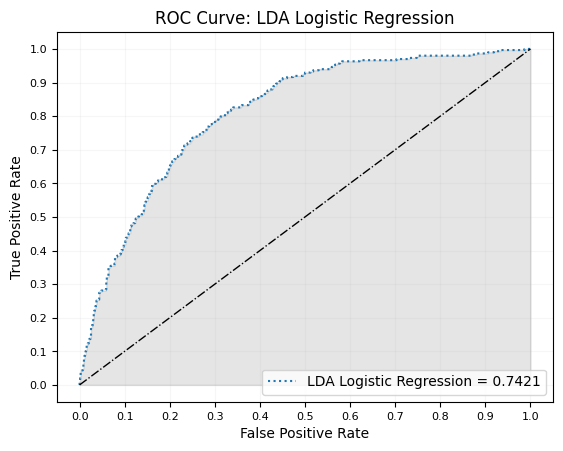

In [62]:
best_models = {}
#  Best unbalanced
# lda_lr_pipe = Pipeline(
#     steps=[
#         ('preprocessing', scaled_preprocessor),
#         ('lda', LDA(n_components=None)),
#         ('logreg', LogisticRegression( solver = "lbfgs", max_iter = 5000, random_state=1, class_weight = 'balanced', fit_intercept = True,
#                                      intercept_scaling = 0.01, penalty = 'l2', tol = 0.001)),
#         ])
#The final cross-fold ROC_AUC score for the  LDA-Logistic Regression is: 0.8463
#The unseen data ROC_AUC score for LDA-Logistic Regression is: 0.7388
#
#
# Best balanced
lda_lr_pipe = Pipeline(
    steps=[
        ('preprocessing', scaled_preprocessor),
        ('undersample' , RandomUnderSampler(sampling_strategy = 1.0, random_state = 1) ),
        ('lda', LDA(n_components=None)),
        ('logreg', LogisticRegression( class_weight = None, C = 0.3, solver = 'liblinear', fit_intercept = True, penalty = 'l2',
                                      tol = 0.001, intercept_scaling = 0.6, max_iter = 10000, random_state=1)),
        ])
#The final cross-fold ROC_AUC score for the  LDA-Logistic Regression is: 0.8491
#The unseen data ROC_AUC score for LDA-Logistic Regression is: 0.7421    (with underselect)
#The unseen data ROC_AUC score for LDA-Logistic Regression is: 0.7350    (with SMOTE) 
lda_lr_pipe.fit(X_train, y_train)


roc_auc_scores = cross_val_score(lda_lr_pipe, X_train, y_train, cv = 5, scoring = 'roc_auc')
print('The final cross-fold ROC_AUC score for the  LDA-Logistic Regression is: %.4f' % np.average(roc_auc_scores) )
y_pred = lda_lr_pipe.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print('The unseen data ROC_AUC score for LDA-Logistic Regression is: %.4f' % roc_auc )
print()

best_models['LDA LogReg'] = lda_lr_pipe
plot_roc_auc('ROC Curve: LDA Logistic Regression', {'LDA Logistic Regression': lda_lr_pipe},  X_test, y_test )

# CONFUSION MATRIX     
#     classes = lda_lr_pipe.named_steps['lda'].classes_
#     cm = confusion_matrix(y_test, y_pred, labels=classes)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda_lr_pipe.classes_)
#     disp.plot()
#     plt.show()

### Logistic Regression

The final cross-fold ROC_AUC score for the  Logistic Regression is: 0.8503
The unseen data ROC_AUC score for Logistic Regression is: 0.7502



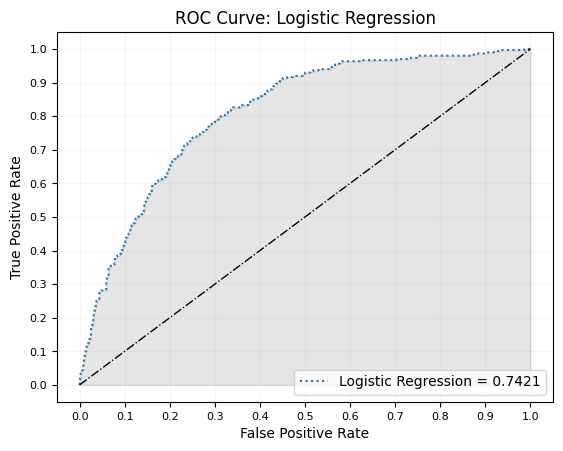

In [63]:
# Best Unbalanced
lr_pipe = Pipeline(
    steps=[
        ('preprocessing', simple_preprocessor),
        ('logreg', LogisticRegression(solver = "lbfgs", random_state=1, C = 0.69, class_weight='balanced',
                                         fit_intercept = True, intercept_scaling = 0.5, 
                                         max_iter = 5000, penalty = 'l2', tol = 0.005)),
        ])
# The final cross-fold ROC_AUC score for the  Logistic Regression is: 0.8503
# The unseen data ROC_AUC score for Logistic Regression is: 0.7502

#Best Balanced
# lr_pipe = Pipeline(
#         steps=[
#             ('preprocessing', simple_preprocessor),
#             ('undersample' , RandomUnderSampler(sampling_strategy = 1.0, random_state = 1) ),
#             ('logreg', LogisticRegression(solver = "liblinear", random_state=1, C = 0.30, class_weight=None,
#                                           fit_intercept = True, intercept_scaling = 0.6, 
#                                           max_iter = 10000, penalty = 'l2', tol = 0.001)),
#             ])
#The final cross-fold ROC_AUC score for the  Logistic Regression is: 0.8498
#The unseen data ROC_AUC score for Logistic Regression is: 0.7490 (with undersample)
#The unseen data ROC_AUC score for Logistic Regression is: 0.7159 (with SMOTE)

lr_pipe.fit(X_train, y_train)
roc_auc_scores = cross_val_score(lr_pipe, X_train, y_train, cv = 5, scoring = 'roc_auc')
print('The final cross-fold ROC_AUC score for the  Logistic Regression is: %.4f' % np.average(roc_auc_scores) )
y_pred = lr_pipe.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print('The unseen data ROC_AUC score for Logistic Regression is: %.4f' % roc_auc )
print()
best_models['LogReg'] = lr_pipe
plot_roc_auc('ROC Curve: Logistic Regression', {'Logistic Regression': lda_lr_pipe},  X_test, y_test )

### Support Vector Machine Classifier

The final cross-fold ROC_AUC score for the  SVM Classifier is: 0.8482
The unseen data ROC_AUC score for the SVM Classifier is: 0.7402



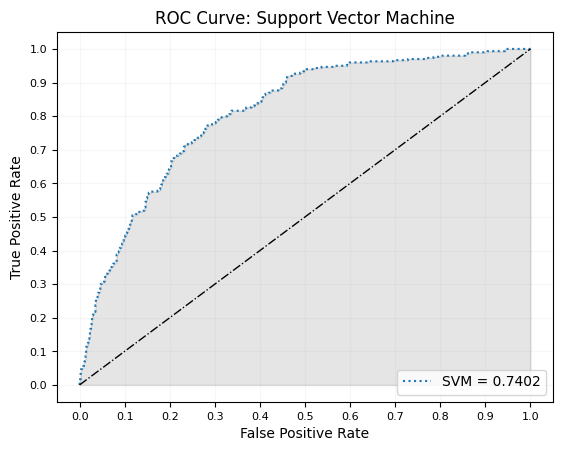

In [64]:
#Best Unbalanced
# svc_pipe = Pipeline(
#     steps=[
#         ('preprocessing', scaled_preprocessor),
#         ('select', SelectFromModel( RandomForestClassifier(random_state = 1, n_estimators = 200), max_features=20)),
#         ('svc',SVC(random_state=1,  C = 4, class_weight = 'balanced', gamma = 'scale', kernel = 'linear', probability=True )),  # probability for soft voter

#The final cross-fold ROC_AUC score for the  SVM Classifier is: 0.8438
#The unseen data ROC_AUC score for the SVM Classifier is: 0.7340 (with select)
#The unseen data ROC_AUC score for the SVM Classifier is: 0.7253 (without select)

#Best balanced
svc_pipe = Pipeline(
    steps=[
        ('preprocessing', scaled_preprocessor),
        #('select', SelectFromModel( RandomForestClassifier(random_state = 1, n_estimators = 200), max_features=20)),
        ('undersample' , RandomUnderSampler(sampling_strategy = 1.0, random_state = 1) ),
        ('svc',SVC(random_state=1,  C = 0.028, class_weight = None, gamma = 'auto', kernel = 'linear', probability=True )),  
        ])
#The final cross-fold ROC_AUC score for the  SVM Classifier is: 0.8443
#The unseen data ROC_AUC score for the SVM Classifier is: 0.7273 (undersample with select)
#The unseen data ROC_AUC score for the SVM Classifier is: 0.7402 (undersample without select)
# The unseen data ROC_AUC score for the SVM Classifier is: 0.7265 (using SMOTE)


svc_pipe.fit(X_train, y_train)
roc_auc_scores = cross_val_score(svc_pipe, X_train, y_train, cv = 5, scoring = 'roc_auc')
print('The final cross-fold ROC_AUC score for the  SVM Classifier is: %.4f' % np.average(roc_auc_scores) )
y_pred = svc_pipe.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print('The unseen data ROC_AUC score for the SVM Classifier is: %.4f' % roc_auc )
print()
best_models['SVM'] = svc_pipe
plot_roc_auc('ROC Curve: Support Vector Machine', {'SVM': svc_pipe},  X_test, y_test )

### Decision Tree Classifier

The final cross-fold ROC_AUC score for the  Decision Tree Classifier is: 0.8296
The unseen data ROC_AUC score for the Decision Tree Classifier is: 0.7350



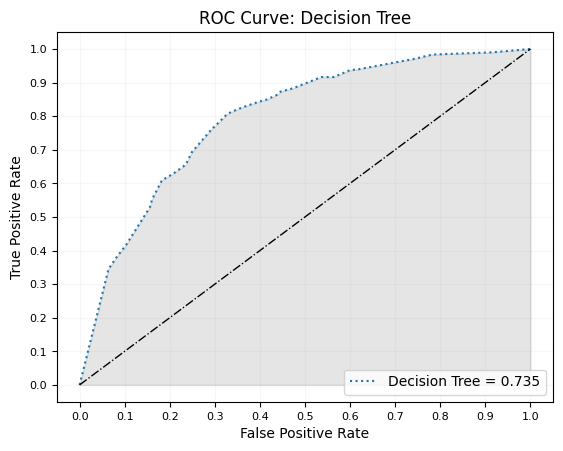

In [65]:
# Best Unbalanced
# dt_pipe = Pipeline(
#     steps=[
#         ('preprocessing', simple_preprocessor),
#         ('decisiontree',DecisionTreeClassifier(random_state = 1, criterion = 'entropy', max_depth = 4, )),
#         ])
#The final cross-fold ROC_AUC score for the  Decision Tree Classifier is: 0.8345
#The unseen data ROC_AUC score for the Decision Tree Classifier is: 0.7160

# Best balanced
dt_pipe = Pipeline(
    steps=[
        ('preprocessing', simple_preprocessor),
        ('undersample' , RandomUnderSampler(sampling_strategy = 1.0, random_state = 1) ),
        ('decisiontree',DecisionTreeClassifier(random_state = 1, criterion = 'gini', max_depth = 5 )),
        ])
#The final cross-fold ROC_AUC score for the  Decision Tree Classifier is: 0.8296
#The unseen data ROC_AUC score for the Decision Tree Classifier is: 0.7350 (with undersample)
#The unseen data ROC_AUC score for the Decision Tree Classifier is: 0.7025 (with SMOTE)


dt_pipe.fit(X_train, y_train)
roc_auc_scores = cross_val_score(dt_pipe, X_train, y_train, cv = 5, scoring = 'roc_auc')
print('The final cross-fold ROC_AUC score for the  Decision Tree Classifier is: %.4f' % np.average(roc_auc_scores) )
y_pred = dt_pipe.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print('The unseen data ROC_AUC score for the Decision Tree Classifier is: %.4f' % roc_auc )
print()
best_models['Decision Tree'] = dt_pipe
plot_roc_auc('ROC Curve: Decision Tree', {'Decision Tree': dt_pipe},  X_test, y_test )

### Random Forest Classifier

The final cross-fold ROC_AUC score for the  Random Forest Classifier is: 0.8501
The unseen data ROC_AUC score for the Random Forest Classifier is: 0.7570



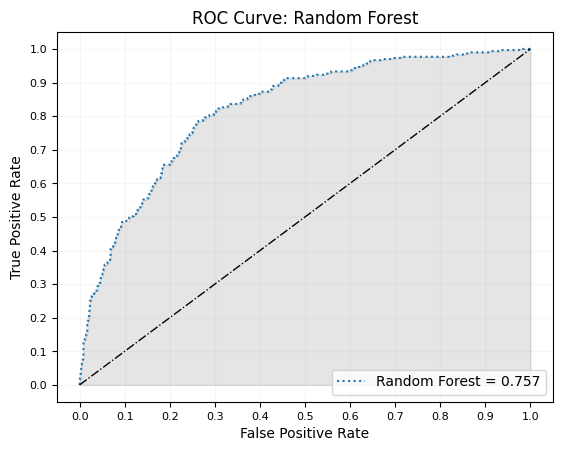

In [66]:
# Best Unbalanced
rf_pipe = Pipeline(
    steps=[
        ('preprocessing', simple_preprocessor),
        #('select', SelectFromModel( RandomForestClassifier(random_state = 1, n_estimators = 200, max_features = 26))),
        ('randomforest',RandomForestClassifier(class_weight = 'balanced', criterion = 'gini', max_features = None, 
                                               n_estimators = 2000, n_jobs = -1, random_state = 1, max_depth = 5)),
        ])
# The final cross-fold ROC_AUC score for the  Random Forest Classifier is: 0.8501
# The unseen data ROC_AUC score for the Random Forest Classifier is: 0.7570 (without select)  -*-
# The unseen data ROC_AUC score for the Random Forest Classifier is: 0.7475 (with select)

# Best balanced
# rf_pipe = Pipeline(
#     steps=[
#         ('preprocessing', simple_preprocessor),
#          ('select', SelectFromModel( RandomForestClassifier(random_state = 1, n_estimators = 200, max_features = 26))),
#         ('undersample' , RandomUnderSampler(sampling_strategy = 1.0, random_state = 1) ),
#         ('randomforest',RandomForestClassifier(class_weight = None, criterion = 'entropy', max_features = None, 
#                                                n_estimators = 2000, n_jobs = -1, random_state = 1, max_depth = 4)),
#         ])


#The final cross-fold ROC_AUC score for the  Random Forest Classifier is: 0.8438
#The unseen data ROC_AUC score for the Random Forest Classifier is: 0.7455 (undersample then select)
#The unseen data ROC_AUC score for the Random Forest Classifier is: 0.7477 (select then undersample)
#The unseen data ROC_AUC score for the Random Forest Classifier is: 0.7478 (undersample without select)
#The unseen data ROC_AUC score for the Random Forest Classifier is: 0.7449 (with SMOTE)

rf_pipe.fit(X_train, y_train)
roc_auc_scores = cross_val_score(rf_pipe, X_train, y_train, cv = 5, scoring = 'roc_auc')
print('The final cross-fold ROC_AUC score for the  Random Forest Classifier is: %.4f' % np.average(roc_auc_scores) )
y_pred = rf_pipe.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print('The unseen data ROC_AUC score for the Random Forest Classifier is: %.4f' % roc_auc )
print()
best_models['Random Forest'] = rf_pipe
plot_roc_auc('ROC Curve: Random Forest', {'Random Forest': rf_pipe},  X_test, y_test )



### K-Nearest Neighbors

The final cross-fold ROC_AUC score for the KNN Classifier is: 0.8420
The unseen data ROC_AUC score for the KNN Classifier is: 0.7401



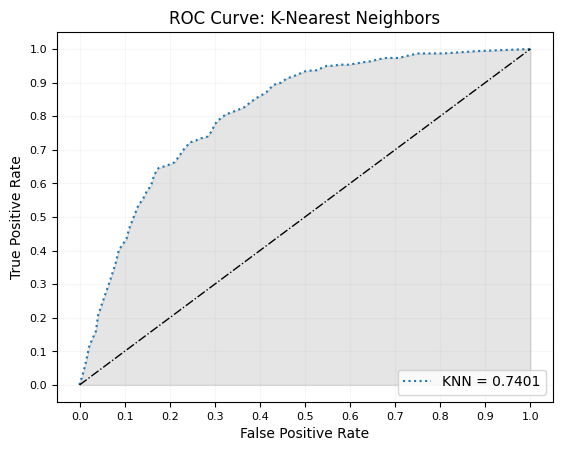

In [67]:
# Best unbalanced
# knn_pipe = Pipeline(steps=[
#     ('preprocessing', scaled_preprocessor),
#     ('select', SelectFromModel( RandomForestClassifier(random_state = 1, n_estimators = 200), max_features=7)),
#     ('estimator',KNeighborsClassifier(metric = 'minkowski', n_neighbors = 61, p = 1,  weights = 'uniform', )),
#     ])
# The final cross-fold ROC_AUC score for the KNN Classifier is: 0.8401
# The unseen data ROC_AUC score for the KNN Classifier is: 0.6919

# Best balanced
knn_pipe = Pipeline(steps=[
    ('preprocessing', scaled_preprocessor),
    ('smote' , SMOTE(sampling_strategy = 1.0, random_state = 1) ),
    ('estimator',KNeighborsClassifier(metric = 'minkowski', n_neighbors = 64, p = 2,  weights = 'uniform', )),
    ])
# The final cross-fold ROC_AUC score for the KNN Classifier is: 0.8441
# The unseen data ROC_AUC score for the KNN Classifier is: 0.7366 (undersample then select)
# The unseen data ROC_AUC score for the KNN Classifier is: 0.7361 (select then undersample)
# The unseen data ROC_AUC score for the KNN Classifier is: 0.7269 (undersample without select)
# The unseen data ROC_AUC score for the KNN Classifier is: 0.7401 (with SMOTE)

knn_pipe.fit(X_train, y_train)
roc_auc_scores = cross_val_score(knn_pipe, X_train, y_train, cv = 5, scoring = 'roc_auc')
print('The final cross-fold ROC_AUC score for the KNN Classifier is: %.4f' % np.average(roc_auc_scores) )
y_pred = knn_pipe.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print('The unseen data ROC_AUC score for the KNN Classifier is: %.4f' % roc_auc )
print()
best_models['K Nearest'] = knn_pipe
plot_roc_auc('ROC Curve: K-Nearest Neighbors', {'KNN': knn_pipe},  X_test, y_test )


### XG Boost Classifier

The final cross-fold ROC_AUC score for the  XGBoost Classifier is: 0.8514
The unseen data ROC_AUC score for the XGBoost Classifier is: 0.7596



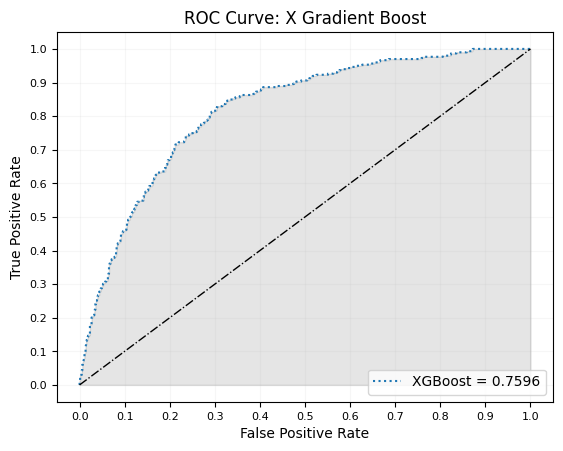

In [68]:
# Best unbalanced
# xgb_pipe = Pipeline(
#     steps=[
#         ('preprocessing', scaled_preprocessor),
#         ('XGBClassifier',xgb.XGBClassifier(random_state=1, learning_rate = 0.04, max_depth = 3, min_child_weight = 8,  n_estimators = 125)),
#         ])
#The final cross-fold ROC_AUC score for the  XGBoost Classifier is: 0.8539
#The unseen data ROC_AUC score for the XGBoost Classifier is: 0.6941

# Best balanced
xgb_pipe = Pipeline(
    steps=[
        ('preprocessing', scaled_preprocessor),
        ('undersample' , RandomUnderSampler(sampling_strategy = 1.0, random_state = 1) ),
        ('XGBClassifier',xgb.XGBClassifier(random_state=1, learning_rate = 0.025, max_depth = 2, min_child_weight = 3,  n_estimators = 575)),
        ])
# The final cross-fold ROC_AUC score for the  XGBoost Classifier is: 0.8514
# The unseen data ROC_AUC score for the XGBoost Classifier is: 0.7596 (with undersample)
# Submitted: 0.7572
# The unseen data ROC_AUC score for the XGBoost Classifier is: 0.7454 (with SMOTE)

xgb_pipe.fit(X_train, y_train)
roc_auc_scores = cross_val_score(xgb_pipe, X_train, y_train, cv = 5, scoring = 'roc_auc')
print('The final cross-fold ROC_AUC score for the  XGBoost Classifier is: %.4f' % np.average(roc_auc_scores) )
y_pred = xgb_pipe.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print('The unseen data ROC_AUC score for the XGBoost Classifier is: %.4f' % roc_auc )
print()
best_models['XG Boost'] = xgb_pipe
plot_roc_auc('ROC Curve: X Gradient Boost', {'XGBoost': xgb_pipe},  X_test, y_test )


### Bagging Classifier

The final cross-fold ROC_AUC score for the Bagging Classifie is: 0.8507
The unseen data ROC_AUC score for the Bagging Classifier is: 0.7448



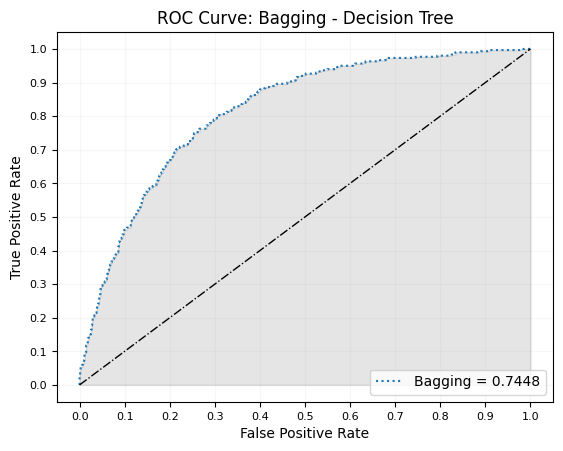

In [69]:
# Best balanced
# dt_bagging = DecisionTreeClassifier(criterion = 'log_loss', max_depth = 8, max_features = 'sqrt', splitter = 'best',
#                             class_weight='balanced',random_state = 1)
# dt_bagging_pipe = Pipeline(
#     steps=[
#         ('preprocessing', simple_preprocessor),
#         ('bagging',  BaggingClassifier(dt_bagging,  verbose=0, bootstrap=True, bootstrap_features=False, oob_score = False, n_jobs=-1,
#                                        random_state=1, max_features = 0.9, max_samples = 0.4, n_estimators = 750)),
#         ])
# The final cross-fold ROC_AUC score for the Bagging Classifie is: 0.8488
# The unseen data ROC_AUC score for the Bagging Classifier is: 0.7394

# Best balanced
dt_bagging = DecisionTreeClassifier(criterion = 'log_loss', max_depth = 6, max_features = 'sqrt', splitter = 'best',random_state = 1)
dt_bagging_pipe = Pipeline(
    steps=[
        ('preprocessing', simple_preprocessor),
        ('undersample' , RandomUnderSampler(sampling_strategy = 1.0, random_state = 1) ),
        ('bagging',  BaggingClassifier(dt_bagging,  verbose=0, bootstrap=True, n_jobs=-1,
                                       random_state=1, max_features = 0.9, max_samples = 0.2, n_estimators = 500)),
        ])

#The final cross-fold ROC_AUC score for the Bagging Classifie is: 0.8507
#The unseen data ROC_AUC score for the Bagging Classifier is: 0.7448 (with undersample)
#The unseen data ROC_AUC score for the Bagging Classifier is: 0.7420 (with SMOTE)

dt_bagging_pipe.fit(X_train, y_train)
roc_auc_scores = cross_val_score(dt_bagging_pipe, X_train, y_train, cv = 5, scoring = 'roc_auc')
print('The final cross-fold ROC_AUC score for the Bagging Classifie is: %.4f' % np.average(roc_auc_scores) )
y_pred = dt_bagging_pipe.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print('The unseen data ROC_AUC score for the Bagging Classifier is: %.4f' % roc_auc )
print()
best_models['Bagging'] = dt_bagging_pipe
plot_roc_auc('ROC Curve: Bagging - Decision Tree', {'Bagging': dt_bagging_pipe},  X_test, y_test )


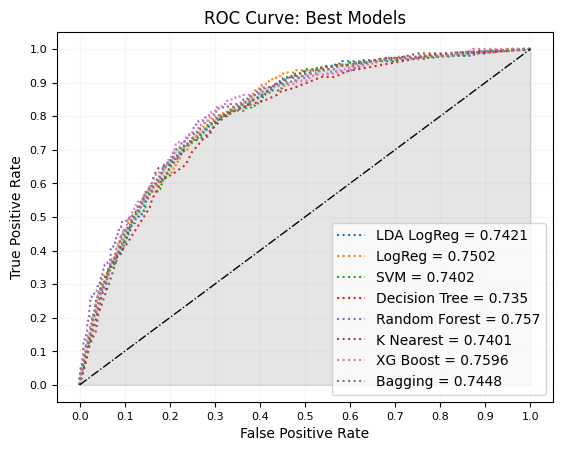

In [70]:
plot_roc_auc('ROC Curve: Best Models', best_models,  X_test, y_test )

In [71]:
voters = []; top_models = {}
voters.append(('xgb_pipe', xgb_pipe))                ; top_models["XGBoost"] = xgb_pipe                         #- 0.760
voters.append(('rf_pipe', rf_pipe))                  ; top_models["Random Forest"] = rf_pipe                    #- 0.757
voters.append(('lr_pipe', lr_pipe))                  ; top_models["Logistic Regression"] = lr_pipe              #- 0.750
# voters.append(('dt_bagging_pipe', dt_bagging_pipe)); top_models["Bagging"] = dt_bagging_pipe                  #- 0.745
# voters.append(('lda_lr_pipe',  lda_lr_pipe))       ; top_models["LDA-LogReg"] = lda_lr_pipe                   #- 0.742
# voters.append(('knn_pipe', knn_pipe))              ; top_models["KNN"] = knn_pipe                             #- 0.740
# voters.append(('svc_pipe', svc_pipe))              ; top_models["SVC"] = svc_pipe                             #- 0.740
# voters.append(('dt_pipe', dt_pipe))                ; top_models["DecisionTree"] = dt_pipe                     #- 0.735

hard_vote = VotingClassifier(estimators = voters, voting ='hard') 
hard_vote.fit(X_train, y_train)
y_pred = hard_vote.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print('The unseen data ROC_AUC score for the Hard Vote is: %.4f' % roc_auc )


soft_vote = VotingClassifier(estimators = voters, voting ='soft') 
soft_vote.fit(X_train, y_train)
roc_auc_scores = cross_val_score(soft_vote, X_train, y_train, cv = 10, scoring = 'roc_auc')
print('The cross-fold ROC_AUC score for the Soft Vote is: %.4f' % np.average(roc_auc_scores) )
y_pred = soft_vote.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print('The unseen data ROC_AUC score for the Soft Vote is: %.4f' % roc_auc )
top_models["TOP 3 Soft Vote"] = soft_vote
print()


The unseen data ROC_AUC score for the Hard Vote is: 0.7575
The cross-fold ROC_AUC score for the Soft Vote is: 0.8548
The unseen data ROC_AUC score for the Soft Vote is: 0.7499



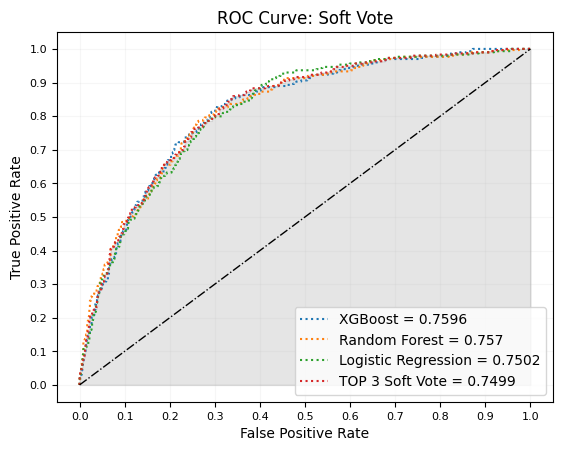

In [72]:

plot_roc_auc('ROC Curve: Soft Vote', top_models,  X_test, y_test )


- For all voters
- The unseen data ROC_AUC score for the Hard Vote is: 0.7236 (v2 - 0.7282) (v3 - 0.7476)
- The unseen data ROC_AUC score for the Soft Vote is: 0.7225 (v2 - 0.7273)
<br><br>
- OUT: lr_pipe                                               (v2 - OUT: knn_pipe) (v3 - OUT: dt_pipe)
- The unseen data ROC_AUC score for the Hard Vote is: 0.7348 (v2 - 0.7421) (v3 - 0.7490)
- The unseen data ROC_AUC score for the Soft Vote is: 0.7195 (v2 - 0.7364)
<br><br>
- OUT: lr_pipe, rf_pipe                                      (v2 - OUT: knn_pipe, rf_pipe) (v3 - OUT: dt_pipe, svc_pipe)
- The unseen data ROC_AUC score for the Hard Vote is: 0.7366 (v2 - 0.7445) (v3 - 0.7483)
- The unseen data ROC_AUC score for the Soft Vote is: 0.7280 (v2 - 0.7343) (v3 - 0.7455)
<br><br>
- OUT: lr_pipe, rf_pipe, xgboost                             (v2 - OUT: knn_pipe, rf_pipe, xgb_pipe) (v3 - OUT: dt_pipe, svc_pipe, knn_pipe)
- The unseen data ROC_AUC score for the Hard Vote is: 0.7461 (v2 - 0.7449) (v3 - 0.7508)
- The unseen data ROC_AUC score for the Soft Vote is: 0.7349 (v2 - 0.7426) (v3 - 0.7468)
<br><br>
- OUT: lr_pipe, rf_pipe, xgb_pipe, knn_pipe                  (v2 - OUT: knn_pipe, rf_pipe, xgb_pipe, dt_pipe) (v3 - OUT: dt_pipe, svc_pipe, knn_pipe, lda_lr_pipe)
- The unseen data ROC_AUC score for the Hard Vote is: 0.7450 (v2 - 0.7417) (v3 - 0.7480)
- The unseen data ROC_AUC score for the Soft Vote is: 0.7343 (v2 - 0.7409) (v3 - 0.7508)
<br><br>
- OUT: lr_pipe, rf_pipe, xgb_pipe, knn_pipe, dt_pipe         (v2 - OUT: knn_pipe, rf_pipe, xgb_pipe, dt_pipe, svc_pipe) (v3 - OUT: dt_pipe, svc_pipe, knn_pipe, lda_lr_pipe, dt_bagging_pipe)
- The unseen data ROC_AUC score for the Hard Vote is: 0.7410 (v2 - 0.7430) (v3 - 0.7575)
- The unseen data ROC_AUC score for the Soft Vote is: 0.7376 (v2 - 0.7469) (v3 - 0.7499)


- Only rf_pipe and xgb_pipe
- (v3) The unseen data ROC_AUC score for the Soft Vote is: 0.7637
- (v3) The unseen data ROC_AUC score for the Soft Vote is: 0.7578

# Submitting 



### Examine TEST data - make sure there are no surprises

In [73]:
TEST_datafile = "/kaggle/input/churn-data-files/test.csv"
df_TEST = pd.read_csv(TEST_datafile)

print(df_TEST.dtypes)
display(df_TEST.head(3))

ID                    int64
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object


,ID,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,438,4376-KFVRS,Male,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),114.05,8468.2
1,2281,2754-SDJRD,Female,1,No,No,8,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),100.15,908.55
2,2236,9917-KWRBE,Female,0,Yes,Yes,41,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,No,One year,Yes,Credit card (automatic),78.35,3211.2


We have the same issue with TotalCharges being a string object as we saw in the training data.  The pipeline's String to Float ColumnTransformer for numerical data should take care of this issue automatically.

In [74]:
df_temp = df_TEST.copy(deep=True)
df_temp['TotalCharges'] = pd.to_numeric(df_temp['TotalCharges'],errors='coerce')
view_rows_with_missing_data(df_temp)

["ID"] had 0 missing values.
Current values include: 7.0 - 7042.0

["customerID"] had 0 missing values.
Current values include: ['4376-KFVRS' '2754-SDJRD' '9917-KWRBE' ... '3675-EQOZA' '3646-ITDGM'
 '3913-FCUUW']

["gender"] had 0 missing values.
Current values include: ['Male' 'Female']

["SeniorCitizen"] had 0 missing values.
Current values include: 0.0 - 1.0

["Partner"] had 0 missing values.
Current values include: ['Yes' 'No']

["Dependents"] had 0 missing values.
Current values include: ['Yes' 'No']

["tenure"] had 0 missing values.
Current values include: 0.0 - 72.0

["PhoneService"] had 0 missing values.
Current values include: ['Yes' 'No']

["MultipleLines"] had 0 missing values.
Current values include: ['Yes' 'No' 'No phone service']

["InternetService"] had 0 missing values.
Current values include: ['Fiber optic' 'DSL' 'No']

["OnlineSecurity"] had 0 missing values.
Current values include: ['Yes' 'No' 'No internet service']

["OnlineBackup"] had 0 missing values.
Current val

There is nothing obviously wrong with the TEST data.  No new values or missing strings.  TotalCharges is missing some values again but this will also be handled by the pipeline's Imputer.

### Predict & Build Submittals

In [75]:


# y_TEST_pred = hard_vote.predict(df_TEST)
# submission = pd.DataFrame({'ID': df_TEST.ID, 'Churn': y_TEST_pred})
# submission.to_csv('hard_vote_2.csv', index=False)

# y_TEST_pred = dt_bagging_pipe.predict(df_TEST)
# submission = pd.DataFrame({'ID': df_TEST.ID, 'Churn': y_TEST_pred})
# submission.to_csv('dt_bagging_pipe_1.csv', index=False)

# y_TEST_pred = soft_vote.predict(df_TEST)
# submission = pd.DataFrame({'ID': df_TEST.ID, 'Churn': y_TEST_pred})
# submission.to_csv('soft_vote_2.csv', index=False)

# y_TEST_pred = lda_lr_pipe.predict(df_TEST)
# submission = pd.DataFrame({'ID': df_TEST.ID, 'Churn': y_TEST_pred})
# submission.to_csv('lda_lr_pipe_1.csv', index=False)

# y_TEST_pred = svc_pipe.predict(df_TEST)
# submission = pd.DataFrame({'ID': df_TEST.ID, 'Churn': y_TEST_pred})
# submission.to_csv('svc_pipe_1.csv', index=False)

y_TEST_pred = lr_pipe.predict(df_TEST)
submission = pd.DataFrame({'ID': df_TEST.ID, 'Churn': y_TEST_pred})
submission.to_csv('lr_pipe_3.csv', index=False)

# y_TEST_pred = dt_bagging_pipe.predict(df_TEST)
# submission = pd.DataFrame({'ID': df_TEST.ID, 'Churn': y_TEST_pred})
# submission.to_csv('dt_bagging_pipe_2.csv', index=False)

# y_TEST_pred = lda_lr_pipe.predict(df_TEST)
# submission = pd.DataFrame({'ID': df_TEST.ID, 'Churn': y_TEST_pred})
# submission.to_csv('lda_lr_pipe_2.csv', index=False)

# y_TEST_pred = rf_pipe.predict(df_TEST)
# submission = pd.DataFrame({'ID': df_TEST.ID, 'Churn': y_TEST_pred})
# submission.to_csv('rf_pipe_1.csv', index=False)

# y_TEST_pred = xgb_pipe.predict(df_TEST)
# submission = pd.DataFrame({'ID': df_TEST.ID, 'Churn': y_TEST_pred})
# submission.to_csv('xgb_pipe_b1.csv', index=False)


# y_TEST_pred = hard_vote.predict(df_TEST)
# submission = pd.DataFrame({'ID': df_TEST.ID, 'Churn': y_TEST_pred})
# submission.to_csv('hard_vote_top5.csv', index=False)

# y_TEST_pred = soft_vote.predict(df_TEST)
# submission = pd.DataFrame({'ID': df_TEST.ID, 'Churn': y_TEST_pred})
# submission.to_csv('soft_vote_top5.csv', index=False)


jobs_finished()

# RESULTS

<span style='color:DarkBlue; font-size:large' >
All of the models were fairly consistent in the low to mid 70s on the ROC-AUC scoring.  Some models performed better when the data was balanced by either undersampling or using SMOTE on the minority class.  Voting nudged the score a ittle higher in some instances but not significantly.
</span>

|Place| Model |  V1 Test AUC |Submit Score|--- |Hard Vote|Soft Vote|
|:---:|---|:---:|:---:|:---:|:---:|:---:|
|1|xgb_pipe|0.760|0.75722||||
|2|rf_pipe|0.757|0.76477|TOP 2:|0.76183|0.76506|
|3|lr_pipe|0.75|0.75232|TOP 3:|0.76108|<b>0.76651</b>|
|4|dt_bagging_pipe|0.745||TOP 4:|0.76365|0.76287|
|5|lda_lr_pipe|0.742||TOP 5:|0.76008|0.76008|
|6|knn_pipe|0.740|||||
|7|svc_pipe|0.740|||||
|8|dt_pipe|0.735|||||

<span style='color:DarkBlue; font-size:large' >
Top final scorer was the VotingClassifier containing the top 3 performing models.
</span>

# FINAL THOUGHTS
<span style='color:DarkBlue; font-size:large' >
The team did a great job dividing the time and skills toward a nice result.  
Items we all found useful during this project included:<br>
    
- Sharing ideas on how the features were related and their importance to the target Churn 
- Using pipelines and ColumnTransformers to simplify the manipulation of data during feature processing
- Saving valuable time by discussing which ideas were not working out as well as those that were.
    
What we would have done different...
- Put Randomized searches to better use.  They seem faster and just as thorough.
- Gone in depth more over some of the hyperparameters we have not covered in class to see how they might help.
</span>